<a href="https://colab.research.google.com/github/oheckmann/Cloud/blob/main/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Homework 1, by Owen Heckmann - 801005079                                           
Github link: 

In [221]:
import torch

from torchvision import transforms

from PIL import Image

The first step in any pytorch project is to import pytorch, as well as some basic handlers, especialy related to images.

Problem 1: 
To begin, I took three images, one being primarily red, another being primaily, blue and another being primarily green. I started by normalinzing hte images by transforming them into .jpgs that were 256-by-256 pixels. After opening them, and displaying the pictures, I then proceeded to turn each image into a tensor so that it could be pre-processed. Finally, I took the .mean() method to get a sense of how bright the image was. The image of the blue man group was not very bright, the image of the green clock was bright, and the image of the redbox was in between.

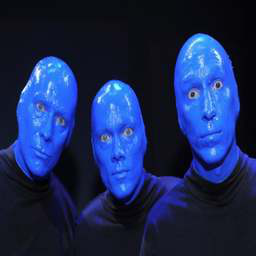

In [222]:
blue = Image.open("drive/MyDrive/images/bluemen_256x256.jpg")
blue

In [223]:
convert_tensor = transforms.ToTensor()
bluet = convert_tensor(blue)

In [224]:
bluet.mean()

tensor(0.1998)

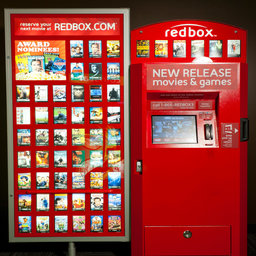

In [225]:
red = Image.open("drive/MyDrive/images/redbox_256x256.jpg")
red

In [226]:
convert_tensor = transforms.ToTensor()
redt = convert_tensor(red)
redt.mean()

tensor(0.3655)

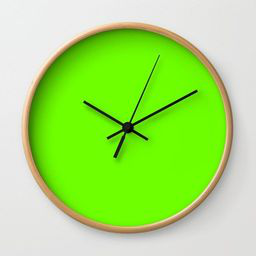

In [227]:
green = Image.open("drive/MyDrive/images/greenclock_256x256.jpg")
green

In [228]:
convert_tensor = transforms.ToTensor()
greent = convert_tensor(green)
greent.mean()

tensor(0.6608)

Next, I took the means of each of the color channels for each of the three different images. As a regular user of GIMP - which is an open-source equivalent of Photoshop - I have using similar recoloring tools in images. As I knew that by adding an RGB vector, you can recolor the image, I was fairly confident that you could itentifiy the different colored images from the channel averages, and this is correct. The dominant color channel is the tensor with the highest average mean, and this is true for each of the images.

In [229]:
R_mean, G_mean ,B_mean = torch.mean(greent, dim = [1,2])
print(R_mean)
print(G_mean)
print(B_mean)

tensor(0.6519)
tensor(0.8869)
tensor(0.4434)


In [230]:
R_mean, G_mean ,B_mean = torch.mean(bluet, dim = [1,2])
print(R_mean)
print(G_mean)
print(B_mean)

tensor(0.1007)
tensor(0.1602)
tensor(0.3386)


In [231]:
R_mean, G_mean ,B_mean = torch.mean(redt, dim = [1,2])
print(R_mean)
print(G_mean)
print(B_mean)

tensor(0.5967)
tensor(0.2635)
tensor(0.2363)


Part 2:

Following on the example done in class, I modified the gradient decent program that was done in class. During a previous class, I duplicated this exact example in MATLAB.

In [232]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

Loading the dataset as tensors

In [233]:
def model(t_u, w1, w2, b):
  return w2 * t_u ** 2 + w1 * t_u + b

Here the model is defined as was instructed in the homework instructions.

There were only a few modifications needed to made the new model work. Most notably, this involved defining and extra w1 variable, and inserting it into any function that preiviously had only one w as a member fuction, most notably t_p.

In [234]:
def loss_fn(t_p, t_c):
  squared_diffs = (t_p - t_c)**2
  return squared_diffs.mean()

In [235]:
w1 = torch.ones(()) 
w2 = torch.ones(()) 
b = torch.zeros(())
t_p = model(t_u, w1, w2, b)
t_p

tensor([1310.1901, 3180.7100, 3445.4399, 6789.5103, 3225.9900, 2440.1101,
        1183.1101,  497.0399, 2390.9600, 3708.5601, 4746.9600])

In [236]:
loss = loss_fn(t_p, t_c)
loss

tensor(11709471.)

In [237]:
delta = 0.1
loss_rate_of_change_w = \
(loss_fn(model(t_u, w1 + delta, w2 + delta , b), t_c) -
loss_fn(model(t_u, w1 - delta, w2 - delta, b), t_c)) / (2.0 * delta)

In [238]:
learning_rate = 1e-2
w1 = w1 - learning_rate * loss_rate_of_change_w
w2 = w2 - learning_rate * loss_rate_of_change_w

In [239]:
loss_rate_of_change_b = \
(loss_fn(model(t_u, w1, w2, b + delta), t_c) -
loss_fn(model(t_u, w1, w2, b - delta), t_c)) / (2.0 * delta)
b = b - learning_rate * loss_rate_of_change_b

In [240]:
def dloss_fn(t_p, t_c):
  dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
  return dsq_diffs

In [241]:
def dmodel_dw(t_u, w1, w2, b):
  return t_u

In [242]:
def dmodel_db(t_u, w1, w2, b):
  return 1.0

In [243]:
def grad_fn(t_u, t_c, t_p, w1, w2, b):
  dloss_dtp = dloss_fn(t_p, t_c)
  dloss_dw1 = dloss_dtp * dmodel_dw(t_u, w1, w2, b)
  dloss_dw2 = dloss_dtp * dmodel_dw(t_u, w1, w2, b)
  dloss_db = dloss_dtp * dmodel_db(t_u, w1, w2, b)
  return torch.stack([dloss_dw1.sum(), dloss_dw2.sum(), dloss_db.sum()])


As well as generating an extra dloss_dw. Also, as per instructions the training_loop was modifed to only print important information every 500 epochs, rather than every epoch.

In [244]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
  for epoch in range(1, n_epochs + 1):
    w1, w2, b = params
    t_p = model(t_u, w1, w2, b)
    loss = loss_fn(t_p, t_c)
    grad = grad_fn(t_u, t_c, t_p, w1, w2, b)
    params = params - learning_rate * grad
    if(epoch % 500 == 0):
      print('Epoch %d, Loss %f' % (epoch, float(loss)))
  return params

When the learning rate was 1e-1, the loss overflowed after only 14 Epochs. It should be obvious, then, that this training did not work. The trained line was so distant that when graphed, it did not even show on the graph!

In [245]:
t_un = 0.1 * t_u

In [246]:
  paras1 = training_loop(
  n_epochs = 5000,
  learning_rate = 1e-1,
  params = torch.tensor([1.0, 1.0, 0.0]),
  t_u = t_un,
  t_c = t_c)

Epoch 500, Loss nan
Epoch 1000, Loss nan
Epoch 1500, Loss nan
Epoch 2000, Loss nan
Epoch 2500, Loss nan
Epoch 3000, Loss nan
Epoch 3500, Loss nan
Epoch 4000, Loss nan
Epoch 4500, Loss nan
Epoch 5000, Loss nan


After each training session, the results were graphed using a matlabs based library. Each graph showed the sample data and the line of best fit.

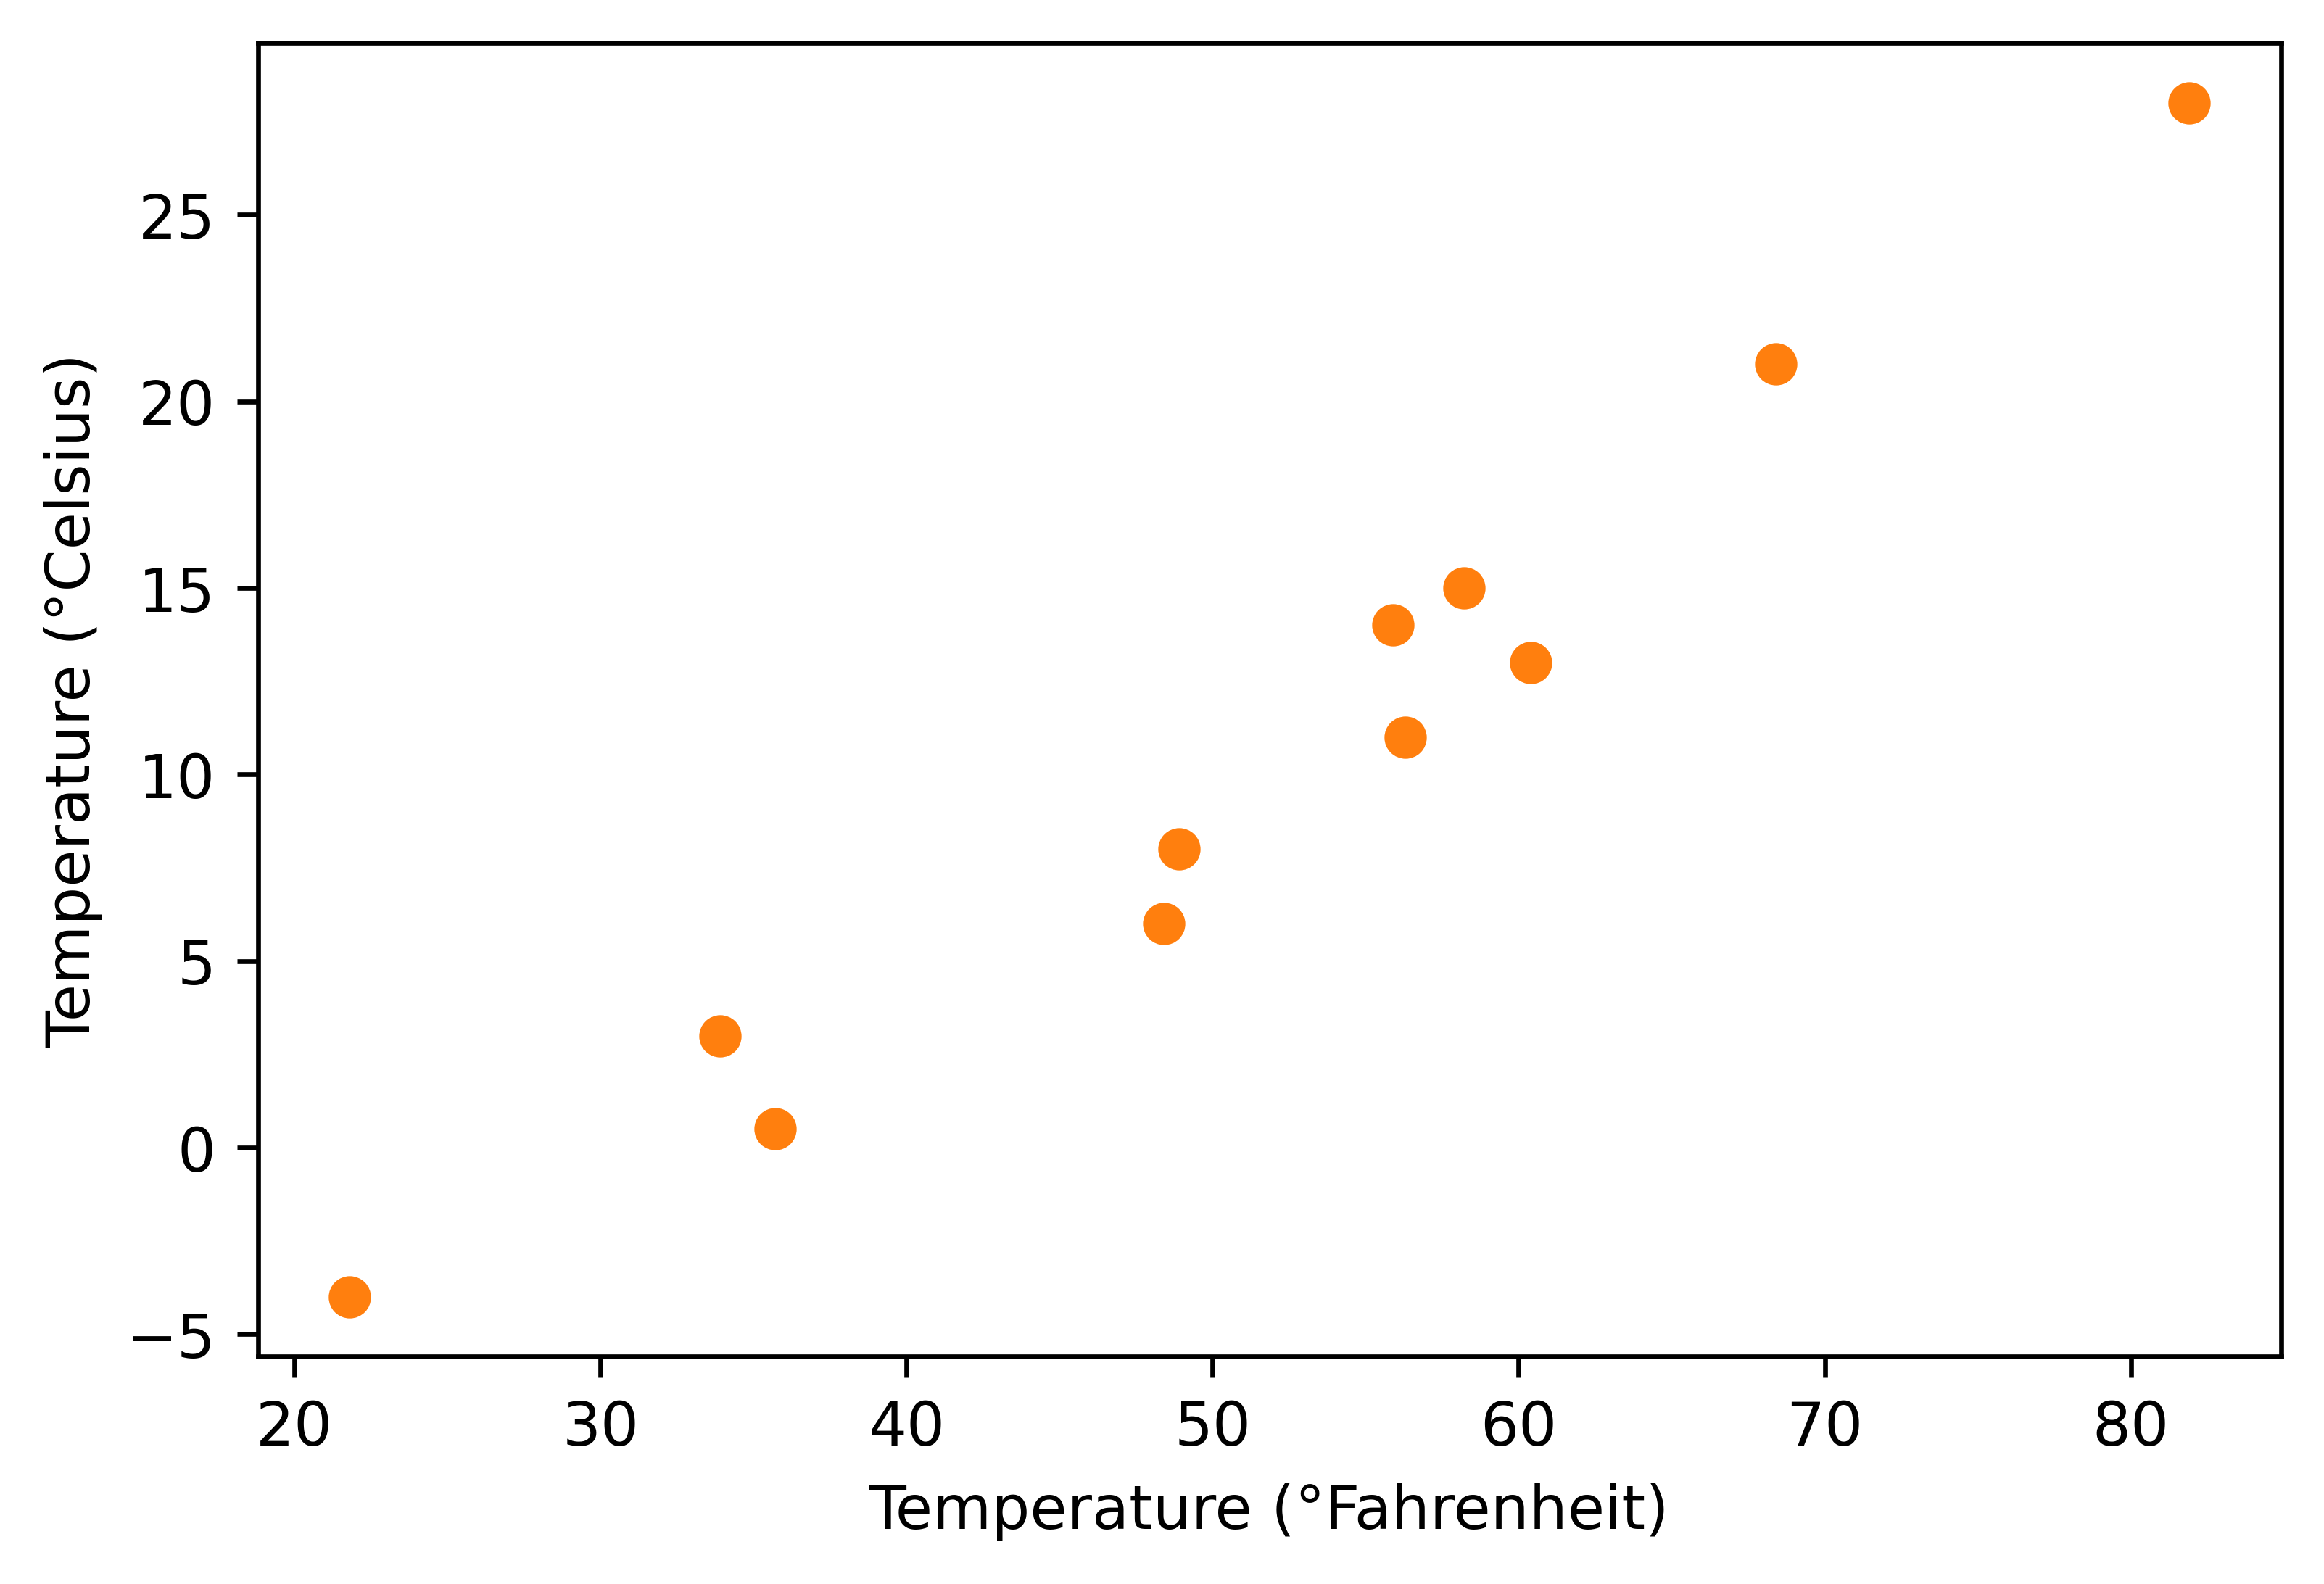

In [247]:
%matplotlib inline
from matplotlib import pyplot as plt
t_p1 = model(t_un, *paras1)
fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p1.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

In [248]:
  paras2 = training_loop(
  n_epochs = 5000,
  learning_rate = 1e-2,
  params = torch.tensor([1.0, 1.0, 0.0]),
  t_u = t_un,
  t_c = t_c)

Epoch 500, Loss nan
Epoch 1000, Loss nan
Epoch 1500, Loss nan
Epoch 2000, Loss nan
Epoch 2500, Loss nan
Epoch 3000, Loss nan
Epoch 3500, Loss nan
Epoch 4000, Loss nan
Epoch 4500, Loss nan
Epoch 5000, Loss nan


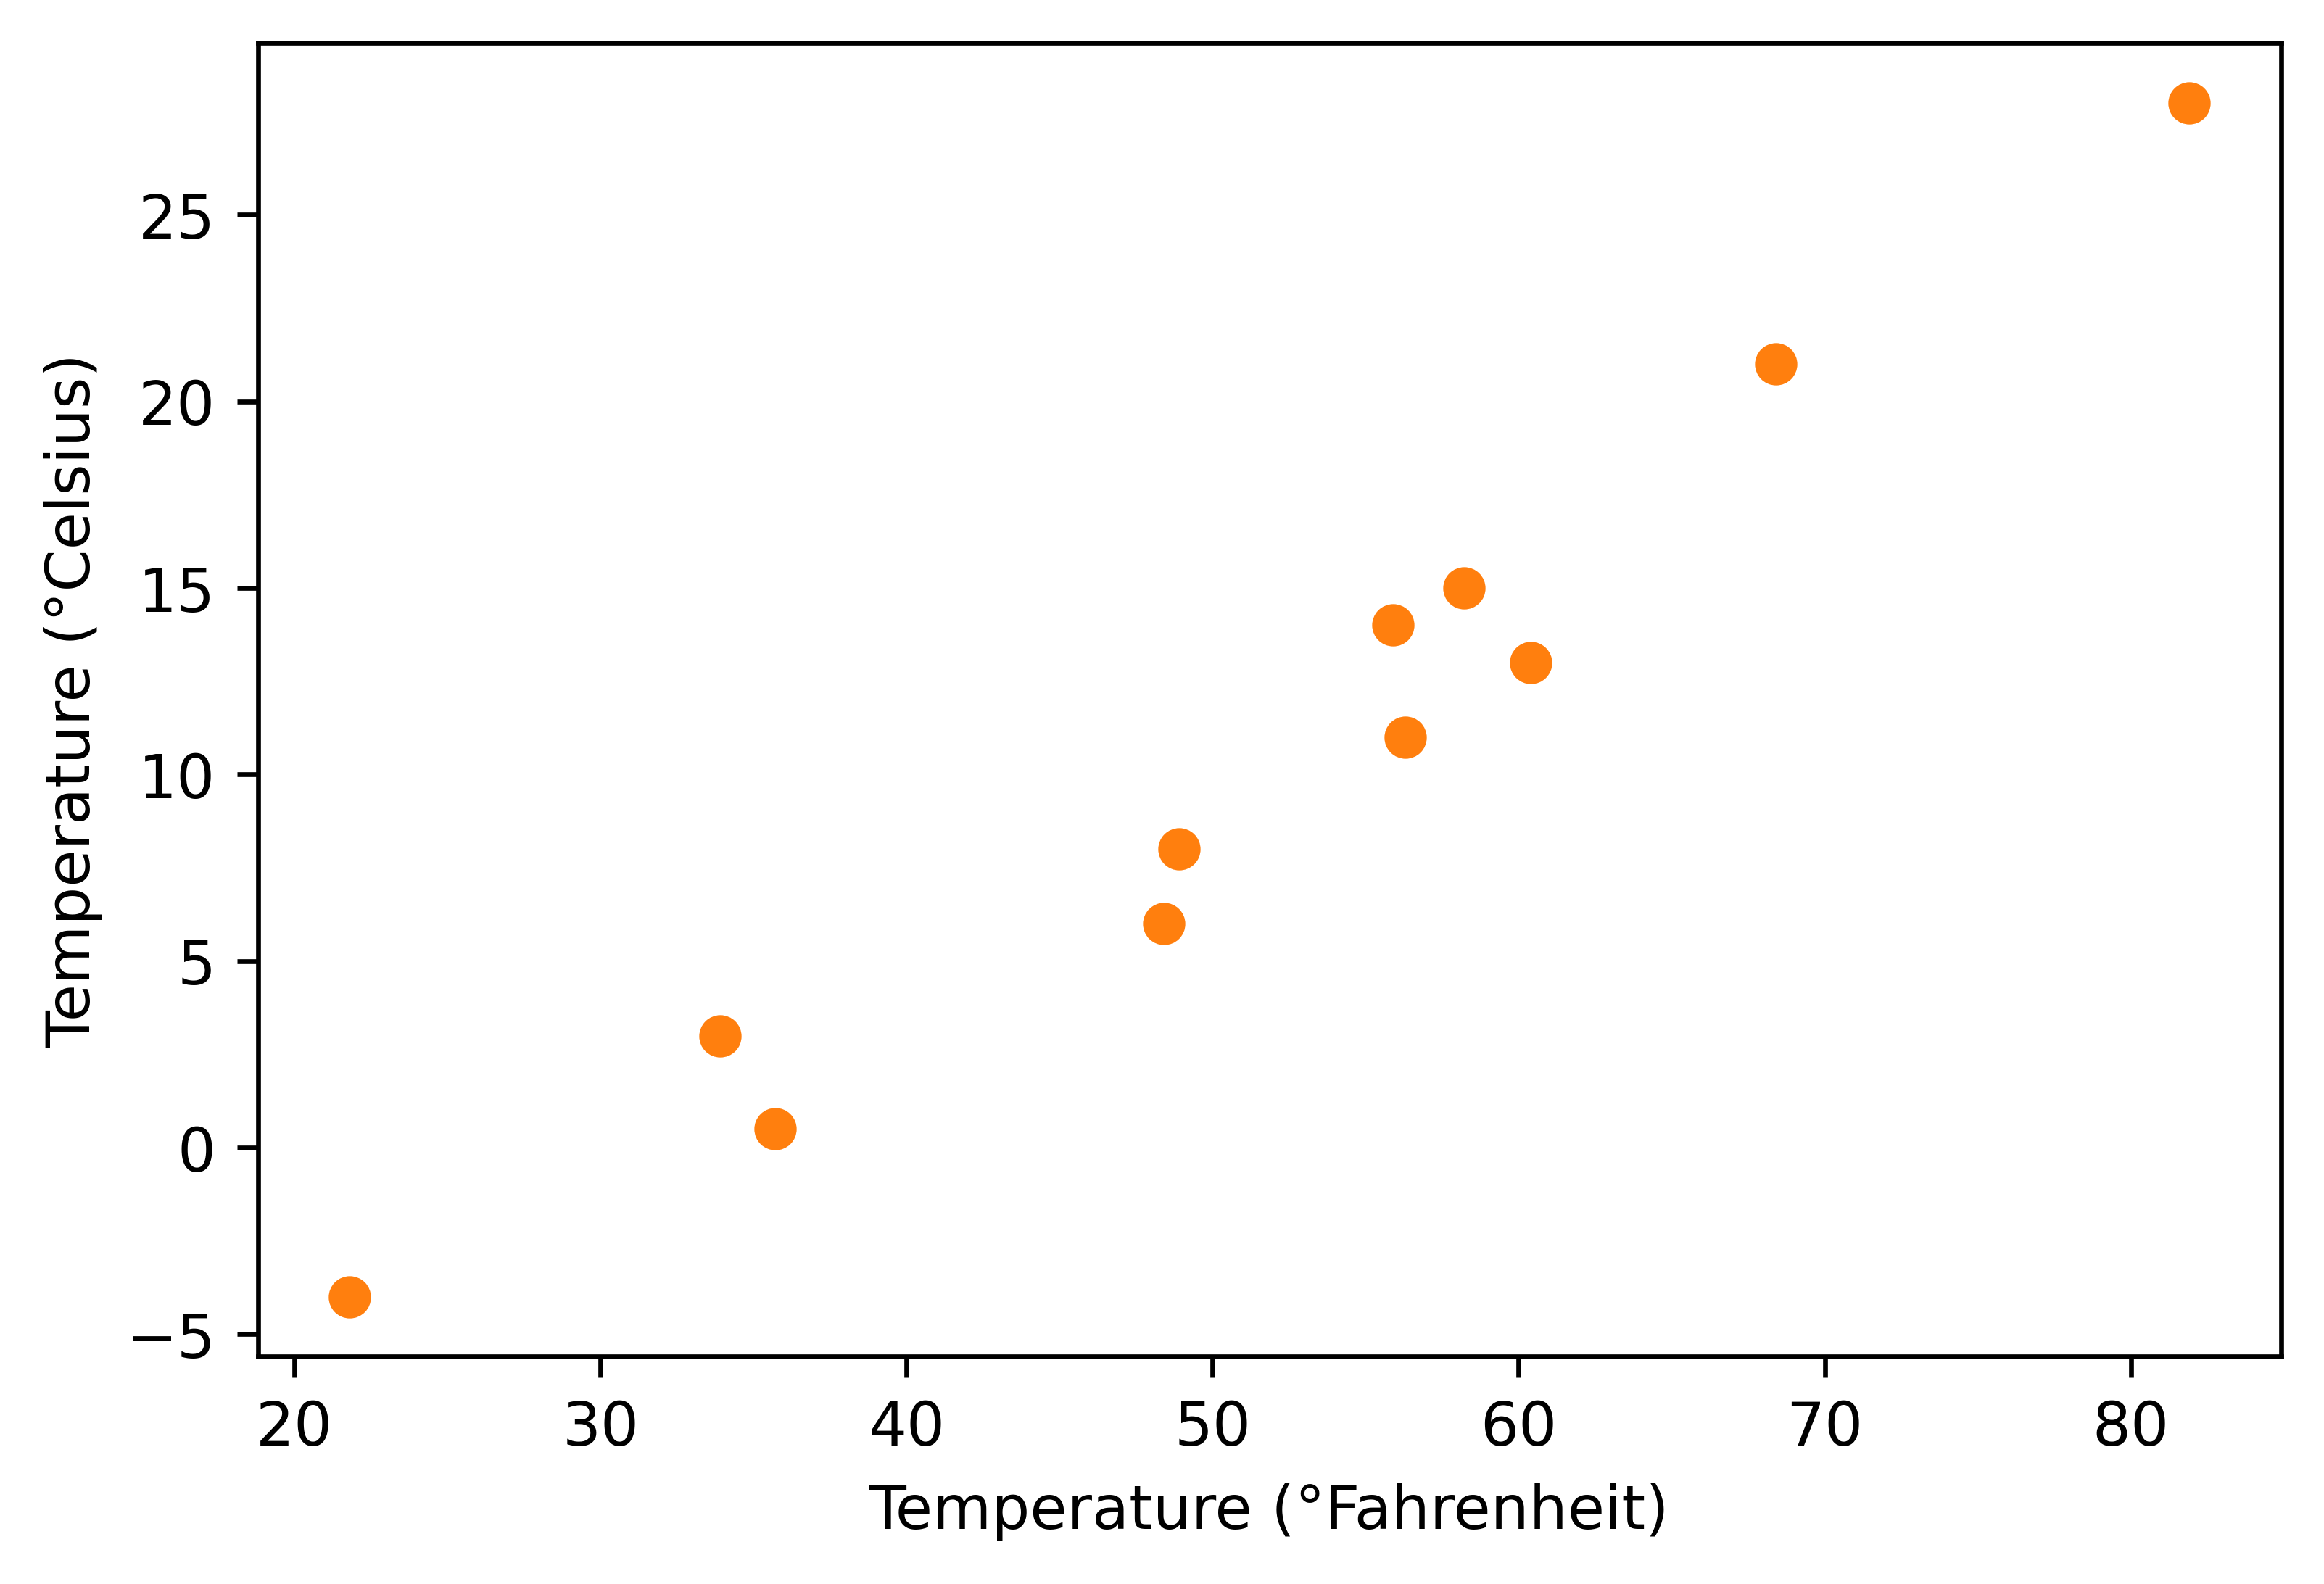

In [249]:
t_p2 = model(t_un, *paras2)
fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p2.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

In [250]:
  paras3 = training_loop(
  n_epochs = 5000,
  learning_rate = 1e-3,
  params = torch.tensor([1.0, 1.0, 0.0]),
  t_u = t_un,
  t_c = t_c)

Epoch 500, Loss 8.035689
Epoch 1000, Loss 6.636409
Epoch 1500, Loss 5.582901
Epoch 2000, Loss 4.790622
Epoch 2500, Loss 4.195589
Epoch 3000, Loss 3.749397
Epoch 3500, Loss 3.415423
Epoch 4000, Loss 3.165985
Epoch 4500, Loss 2.980155
Epoch 5000, Loss 2.842138


When the learning rate is equal to 1e-3, the line of best fit calculated by the regression is actually visible on the graph. 

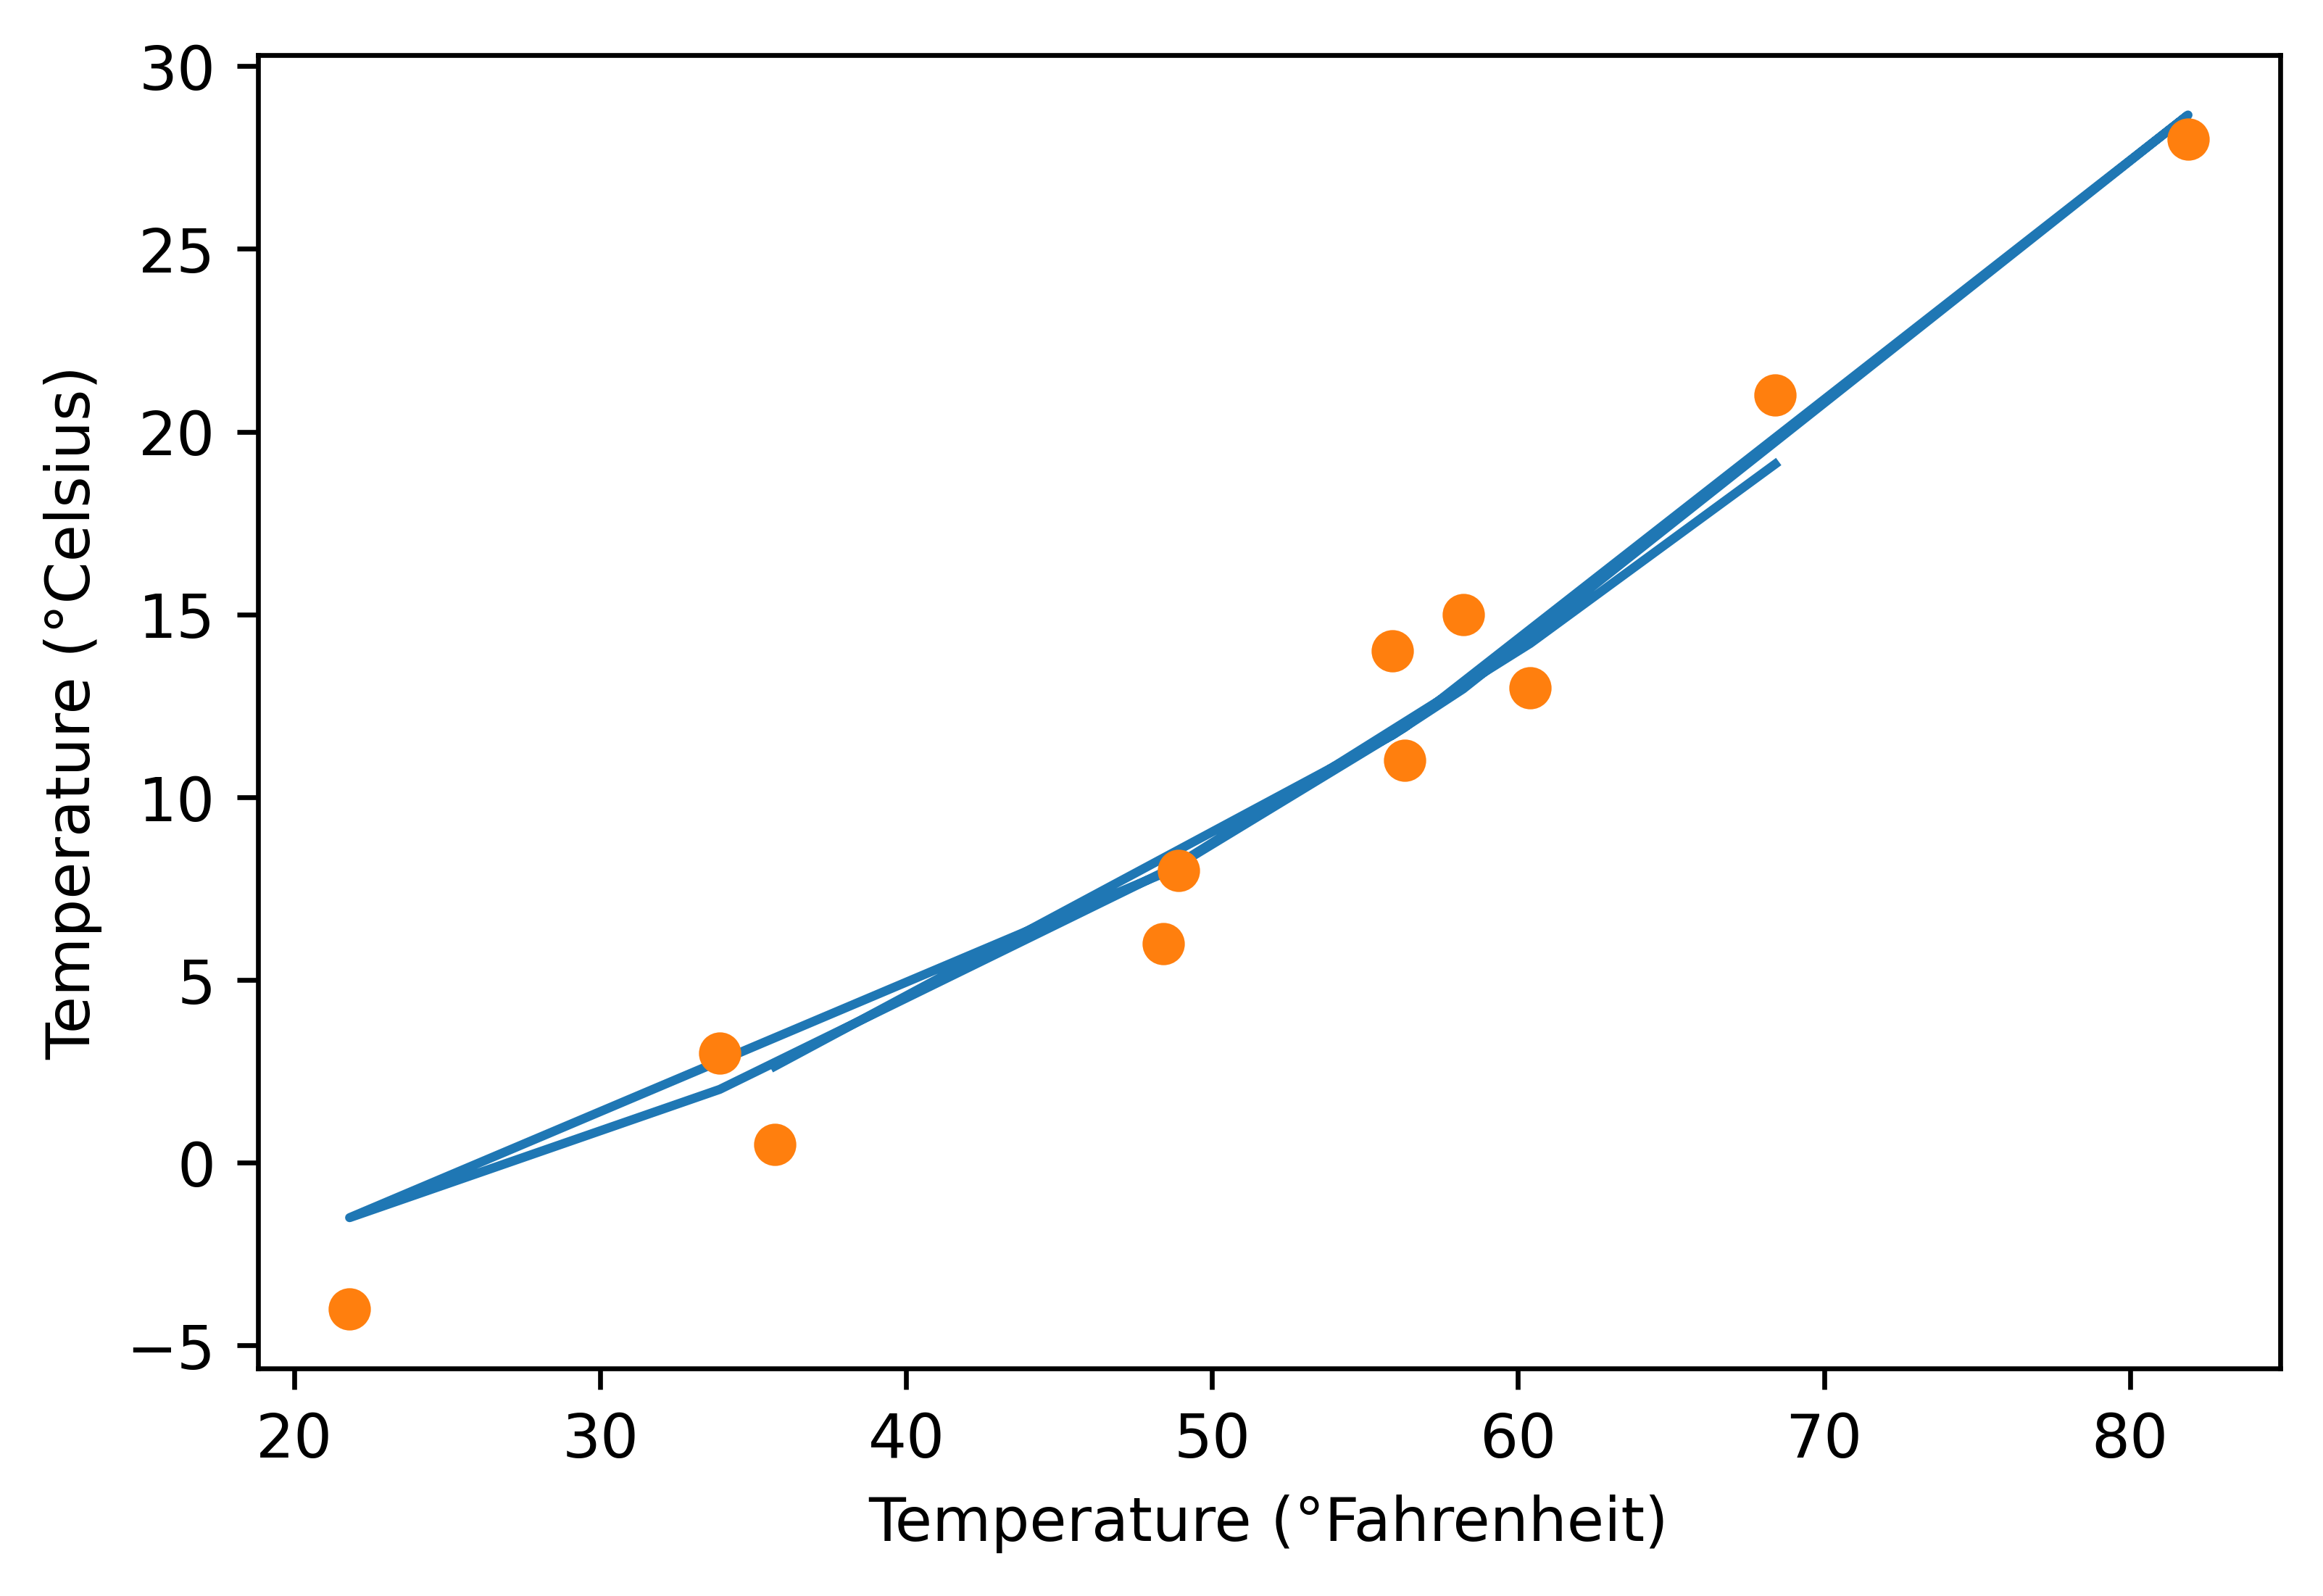

In [251]:
t_p3 = model(t_un, *paras3)
fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p3.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

In [252]:
  paras4 = training_loop(
  n_epochs = 5000,
  learning_rate = 1e-4,
  params = torch.tensor([1.0, 1.0, 0.0]),
  t_u = t_un,
  t_c = t_c)

Epoch 500, Loss 9.678580
Epoch 1000, Loss 9.474418
Epoch 1500, Loss 9.275946
Epoch 2000, Loss 9.082996
Epoch 2500, Loss 8.895410
Epoch 3000, Loss 8.713042
Epoch 3500, Loss 8.535755
Epoch 4000, Loss 8.363424
Epoch 4500, Loss 8.195878
Epoch 5000, Loss 8.033002


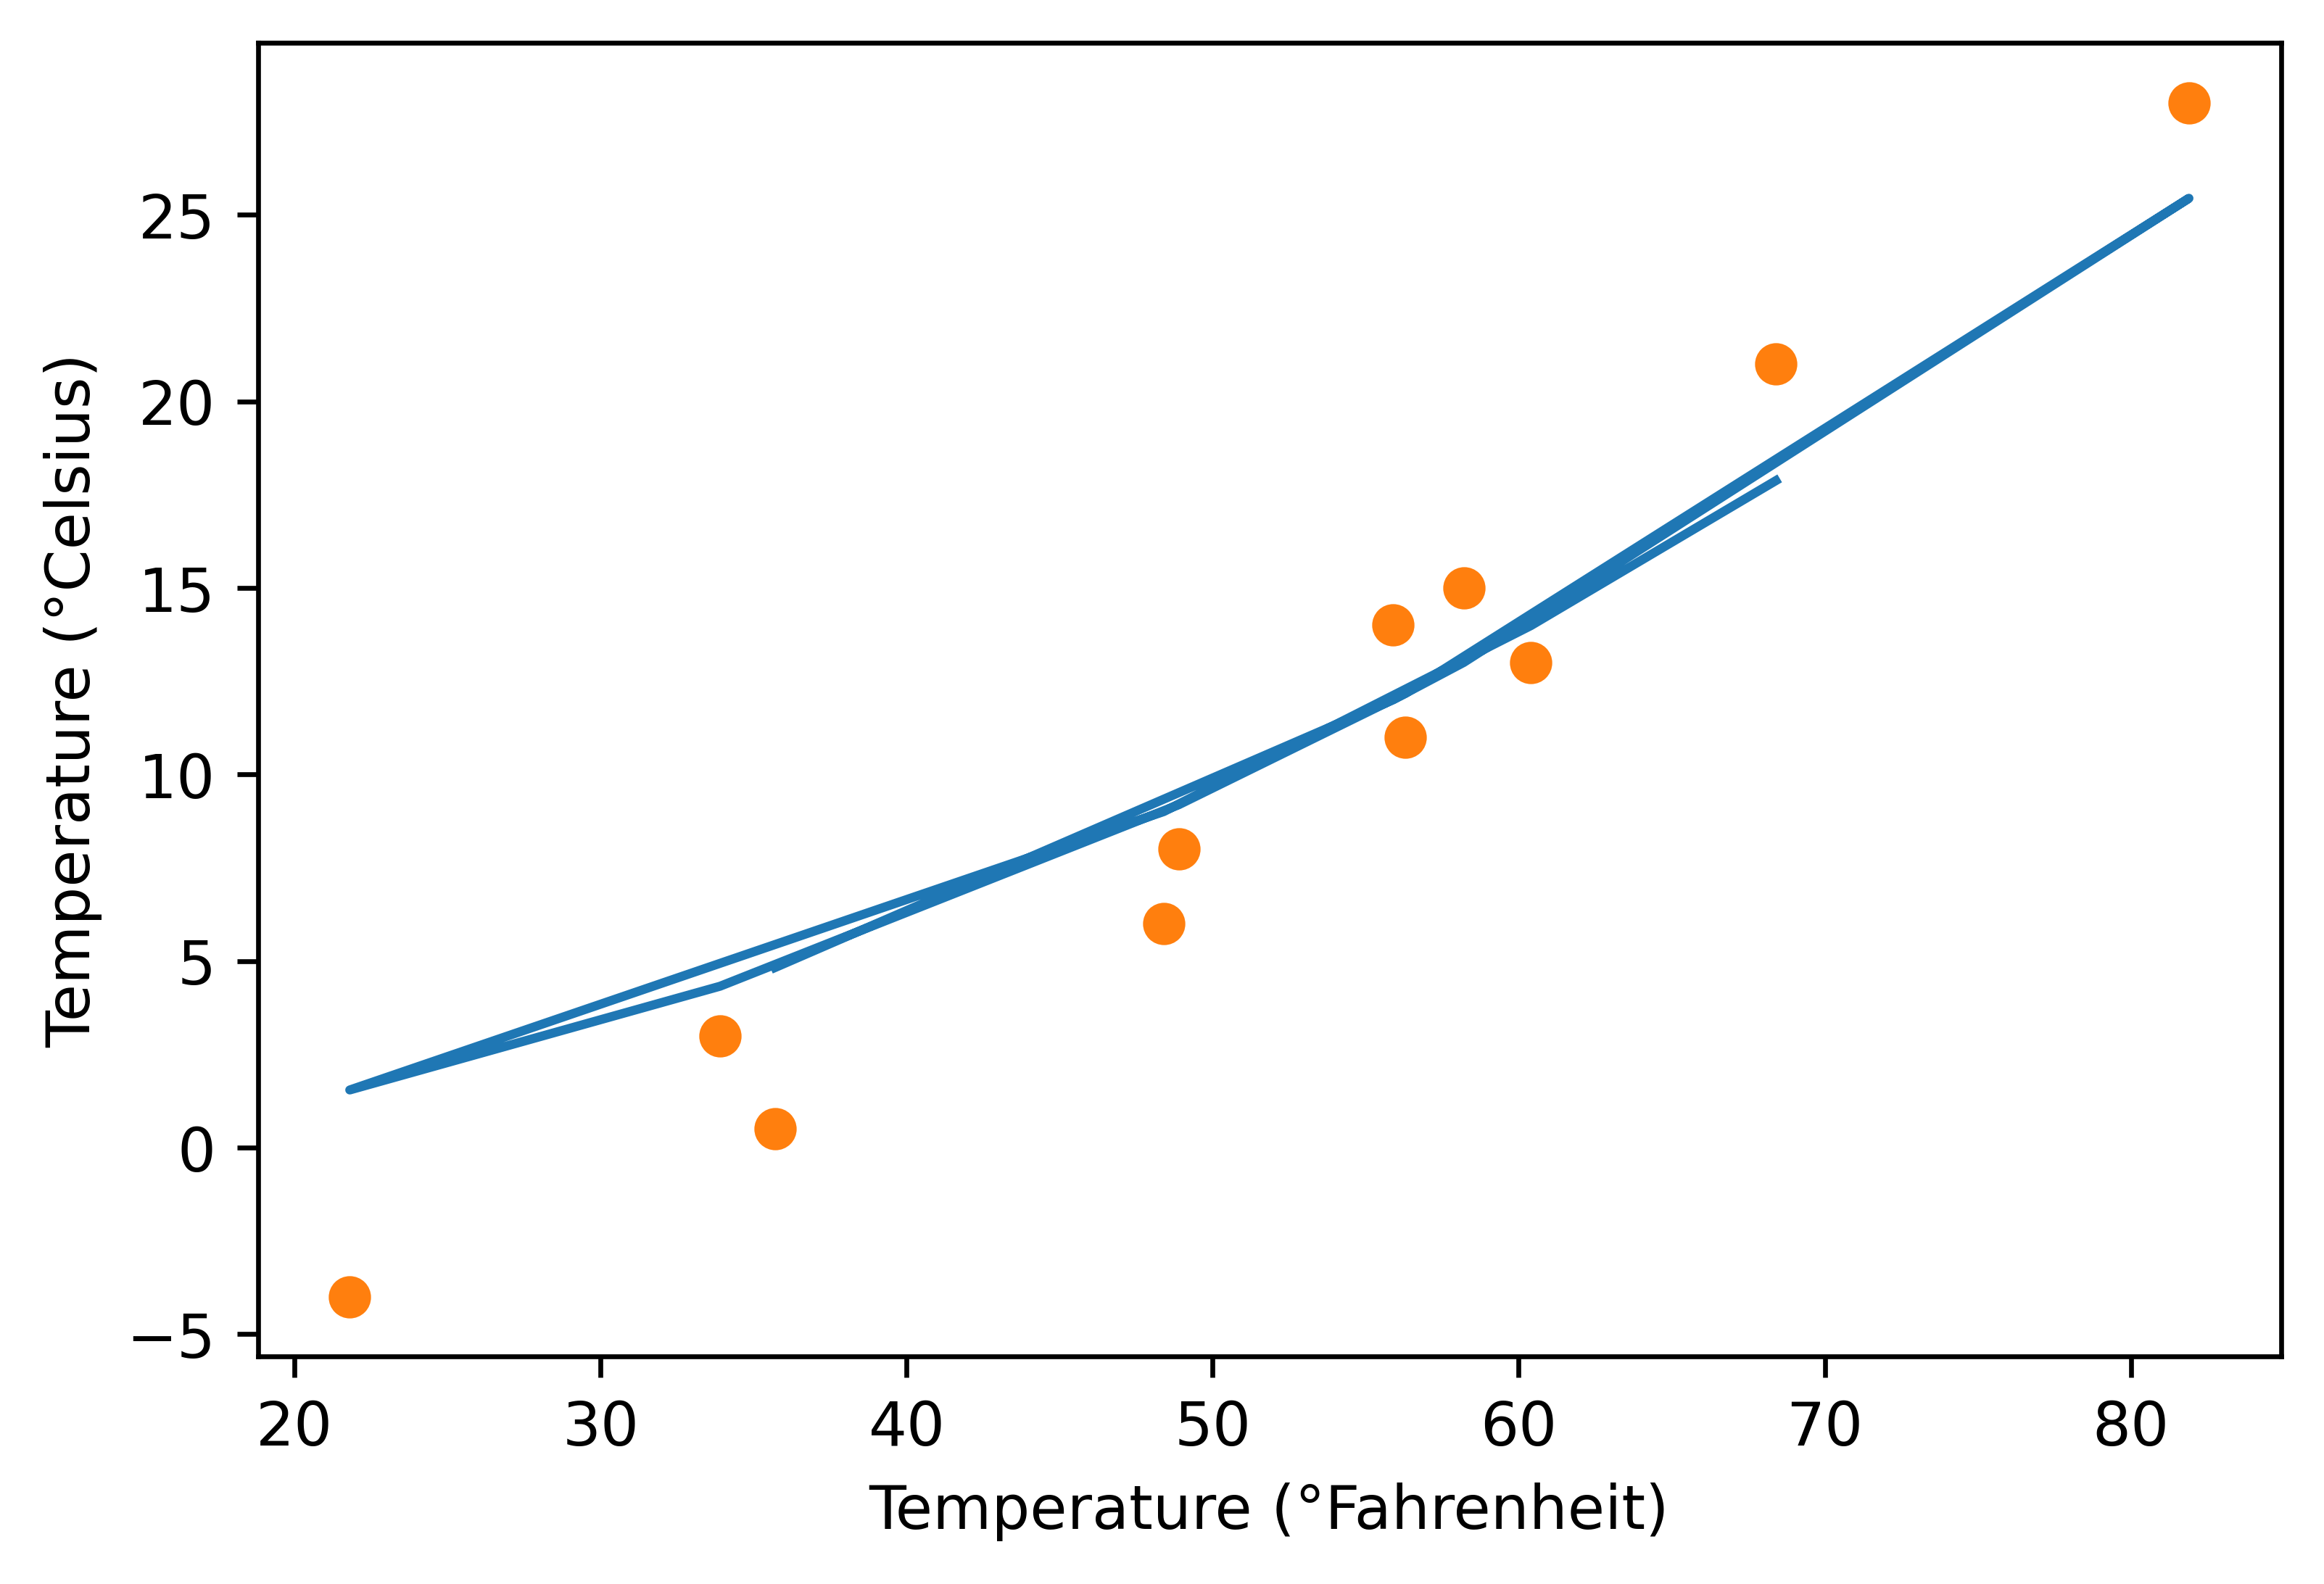

In [253]:
t_p4 = model(t_un, *paras4)
fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p4.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

To compare the linear and non-linear regressions, I duplicated the program from class. As can be seen, by using the same information, the linear regression has a slightly lower loss, at 7.85 compared to the non-linear regression's 8.03. However, neither loss is much different from the other, and in most circumstances, either regression would work perfectly fine.

In [254]:


t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)
def model(t_u, w, b):
  return w * t_u + b
def loss_fn(t_p, t_c):
  squared_diffs = (t_p - t_c)**2
  return squared_diffs.mean()
w = torch.ones(())
b = torch.zeros(())
t_p = model(t_u, w, b)
t_p
loss = loss_fn(t_p, t_c)
loss
delta = 0.1
loss_rate_of_change_w = \
(loss_fn(model(t_u, w + delta, b), t_c) -
loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)
learning_rate = 1e-2
w=w- learning_rate * loss_rate_of_change_w
loss_rate_of_change_b = \
(loss_fn(model(t_u, w, b + delta), t_c) -
loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)
b=b- learning_rate * loss_rate_of_change_b
def loss_fn(t_p, t_c):
  squared_diffs = (t_p - t_c)**2
  return squared_diffs.mean()
def dloss_fn(t_p, t_c):
  dsq_diffs=2* (t_p - t_c) / t_p.size(0)
  return dsq_diffs
def dmodel_dw(t_u, w, b):
  return t_u
def dmodel_db(t_u, w, b):
  return 1.0
def grad_fn(t_u, t_c, t_p, w, b):
  dloss_dtp = dloss_fn(t_p, t_c)
  dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
  dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
  return torch.stack([dloss_dw.sum(), dloss_db.sum()])
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
  for epoch in range(1, n_epochs + 1):
    w, b = params
    t_p = model(t_u, w, b)
    loss = loss_fn(t_p, t_c)
    grad = grad_fn(t_u, t_c, t_p, w, b)
    params = params - learning_rate * grad
    if(epoch % 500 == 0):
      print('Epoch %d, Loss %f' % (epoch, float(loss)))
  return params
t_un = 0.1 * t_u

paral = training_loop(
n_epochs = 5000,
learning_rate = 1e-3,
params = torch.tensor([1.0, 0.0]),
t_u = t_un,
t_c = t_c)
paral

Epoch 500, Loss 25.644270
Epoch 1000, Loss 22.094957
Epoch 1500, Loss 19.100206
Epoch 2000, Loss 16.573353
Epoch 2500, Loss 14.441303
Epoch 3000, Loss 12.642381
Epoch 3500, Loss 11.124518
Epoch 4000, Loss 9.843812
Epoch 4500, Loss 8.763214
Epoch 5000, Loss 7.851448


tensor([ 4.0435, -9.8084])

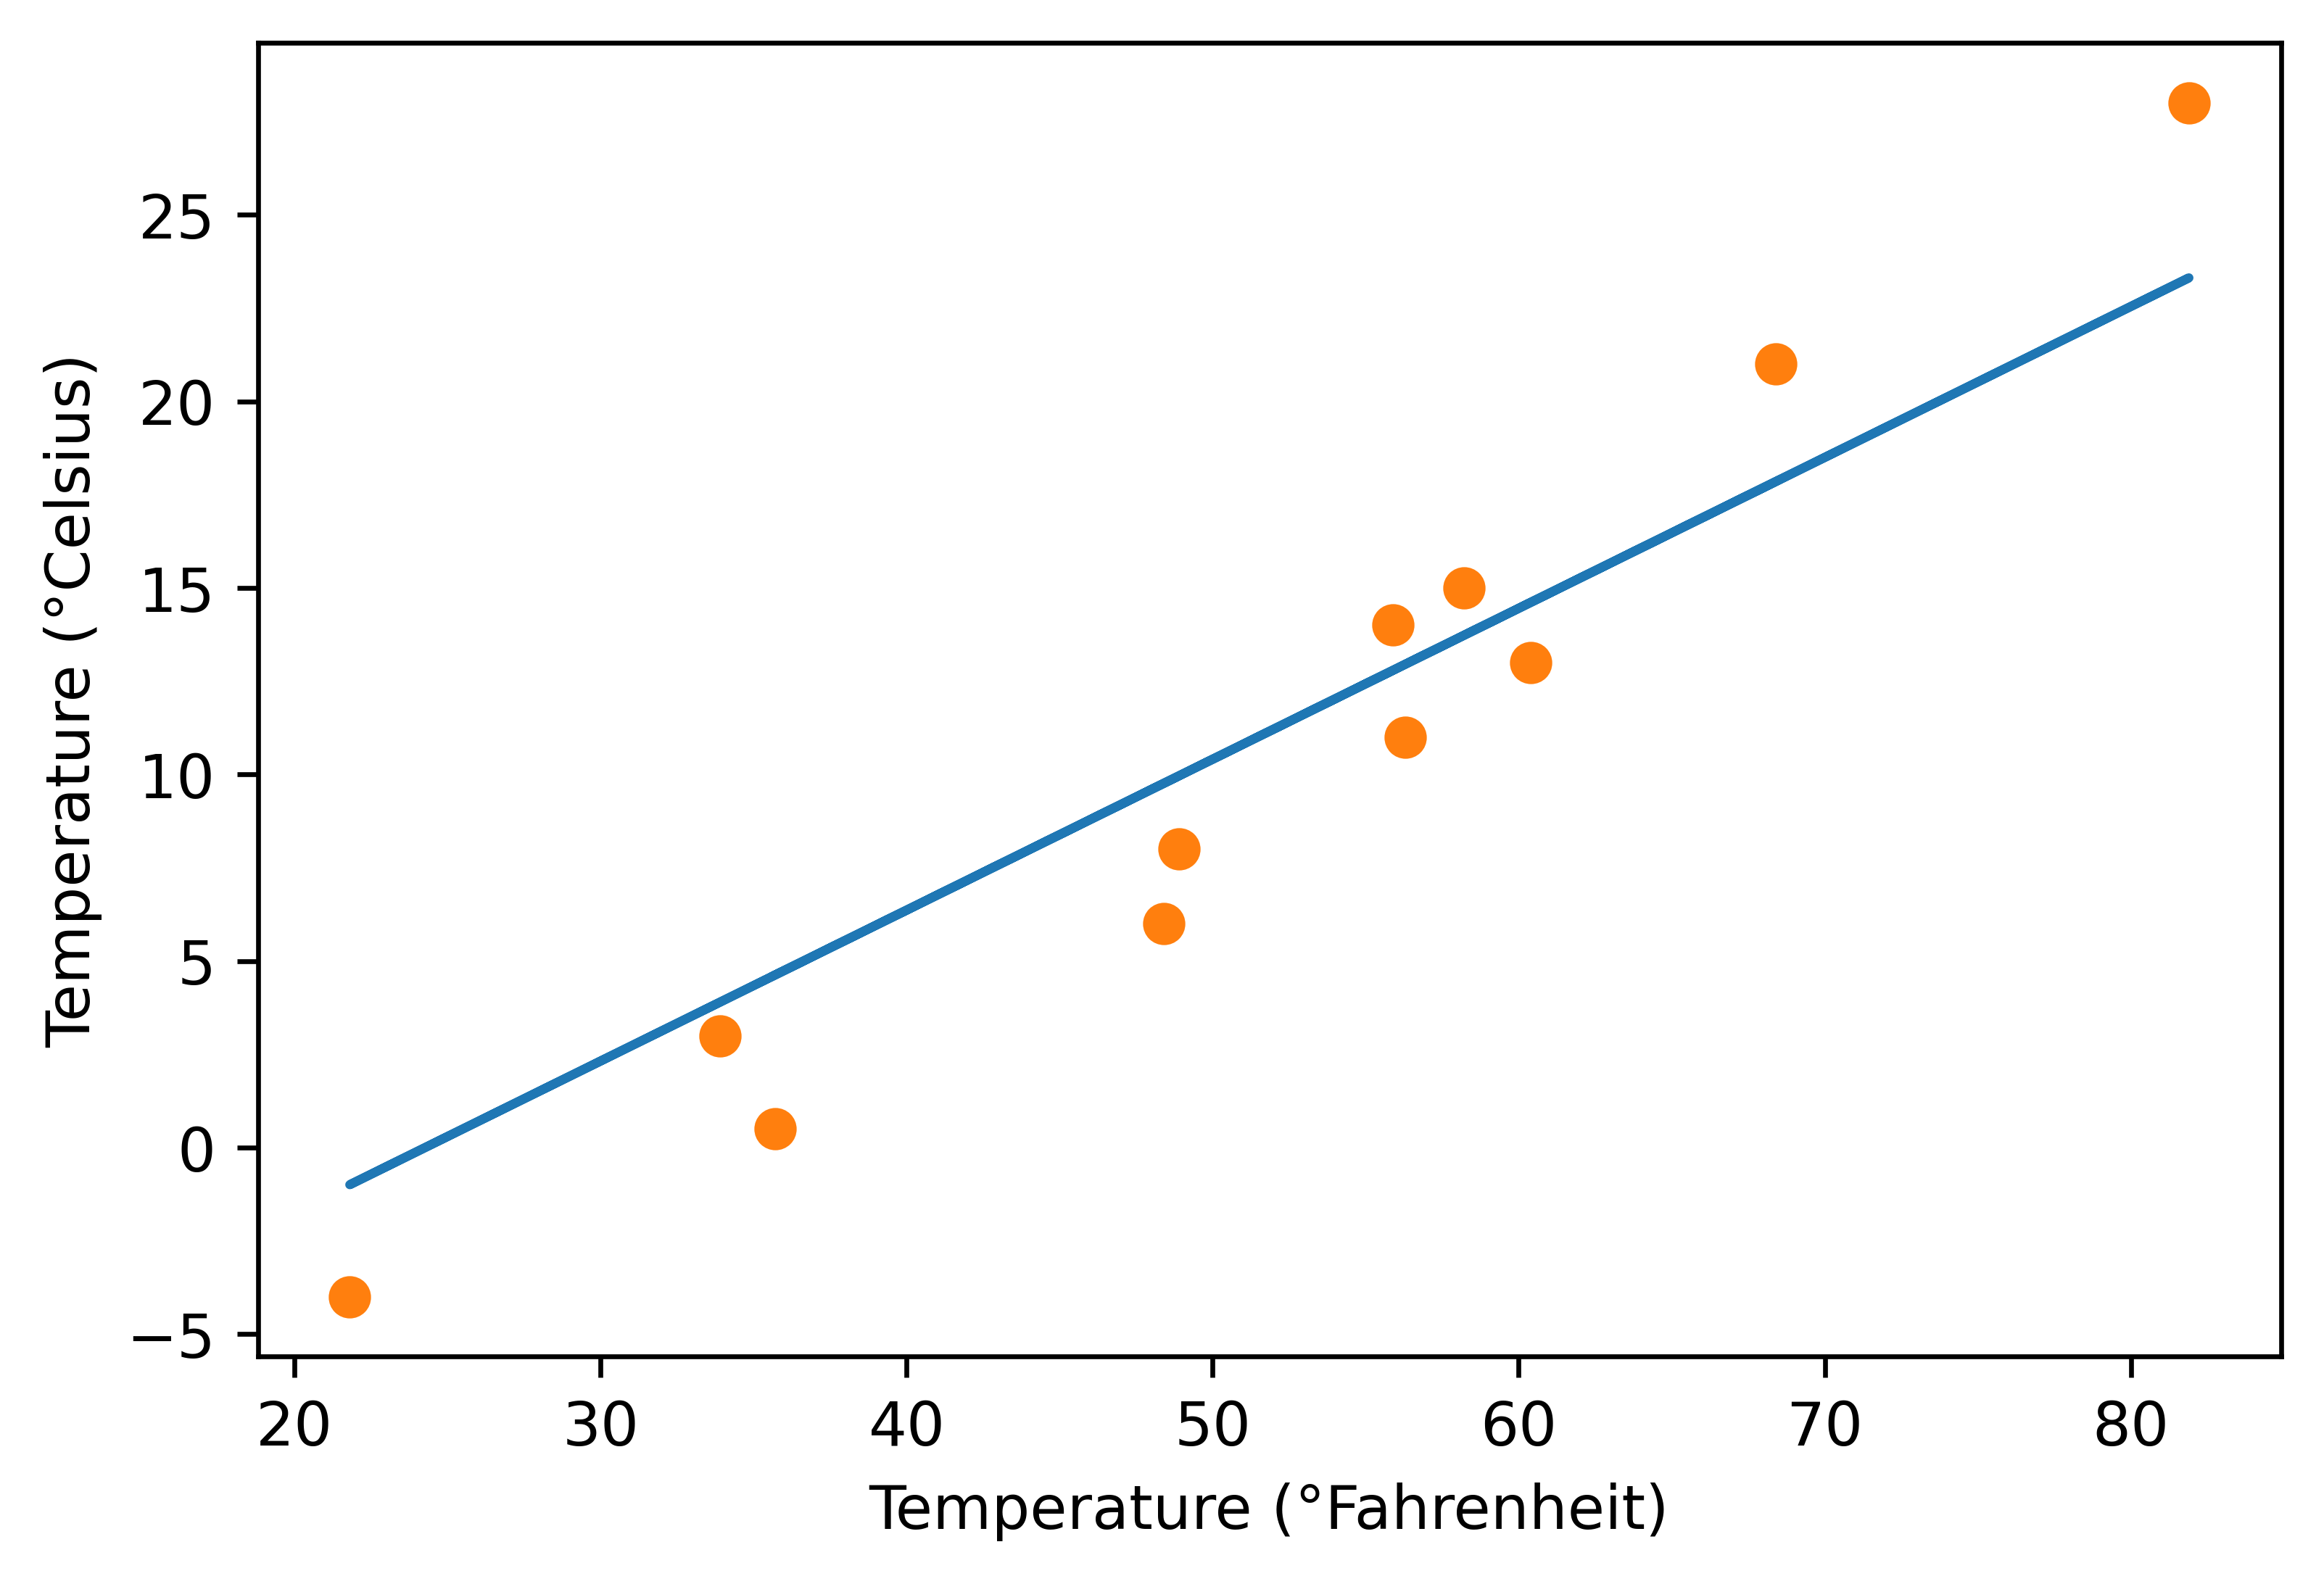

In [255]:
t_pl = model(t_un, *paral)
fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_pl.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

Part 3:

To begin, I imported the Housing .csv file from the canvas page and began to preprocess it in the least efficient way possible. First loading the .csv and stripping the non-numerical information from it. This .csv was then saved to make processing easier.

In [256]:
import pandas as pd

housing = pd.DataFrame(pd.read_csv("drive/MyDrive/images/Housing.csv")) 
housing.head() 

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [257]:
m = len(housing) 
m 

545

In [258]:
housing.shape

(545, 13)

In [259]:
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price'] 
Newtrain = housing[num_vars] 
Newtrain.head() 

,area,bedrooms,bathrooms,stories,parking,price
0,7420,4,2,3,2,13300000
1,8960,4,4,4,3,12250000
2,9960,3,2,2,2,12250000
3,7500,4,2,2,3,12215000
4,7420,4,1,2,2,11410000


In [260]:
Newtrain.shape

(545, 6)

In [261]:
data = Newtrain.to_csv(index=False)
data

'area,bedrooms,bathrooms,stories,parking,price\n7420,4,2,3,2,13300000\n8960,4,4,4,3,12250000\n9960,3,2,2,2,12250000\n7500,4,2,2,3,12215000\n7420,4,1,2,2,11410000\n7500,3,3,1,2,10850000\n8580,4,3,4,2,10150000\n16200,5,3,2,0,10150000\n8100,4,1,2,2,9870000\n5750,3,2,4,1,9800000\n13200,3,1,2,2,9800000\n6000,4,3,2,2,9681000\n6550,4,2,2,1,9310000\n3500,4,2,2,2,9240000\n7800,3,2,2,0,9240000\n6000,4,1,2,2,9100000\n6600,4,2,2,1,9100000\n8500,3,2,4,2,8960000\n4600,3,2,2,2,8890000\n6420,3,2,2,1,8855000\n4320,3,1,2,2,8750000\n7155,3,2,1,2,8680000\n8050,3,1,1,1,8645000\n4560,3,2,2,1,8645000\n8800,3,2,2,2,8575000\n6540,4,2,2,2,8540000\n6000,3,2,4,0,8463000\n8875,3,1,1,1,8400000\n7950,5,2,2,2,8400000\n5500,4,2,2,1,8400000\n7475,3,2,4,2,8400000\n7000,3,1,4,2,8400000\n4880,4,2,2,1,8295000\n5960,3,3,2,1,8190000\n6840,5,1,2,1,8120000\n7000,3,2,4,2,8080940\n7482,3,2,3,1,8043000\n9000,4,2,4,2,7980000\n6000,3,1,4,2,7962500\n6000,4,2,4,1,7910000\n6550,3,1,2,0,7875000\n6360,3,2,4,0,7840000\n6480,3,2,4,2,77000

In [262]:
from pathlib import Path  
filepath = Path('drive/MyDrive/images/out.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
Newtrain.to_csv(filepath)  

In [263]:
import csv
import numpy as np

house_path = "drive/MyDrive/images/out.csv"
houseq_numpy = np.loadtxt(house_path, dtype=np.float, delimiter=",",
skiprows=1)
houseq_numpy

array([[0.000e+00, 7.420e+03, 4.000e+00, ..., 3.000e+00, 2.000e+00,
        1.330e+07],
       [1.000e+00, 8.960e+03, 4.000e+00, ..., 4.000e+00, 3.000e+00,
        1.225e+07],
       [2.000e+00, 9.960e+03, 3.000e+00, ..., 2.000e+00, 2.000e+00,
        1.225e+07],
       ...,
       [5.420e+02, 3.620e+03, 2.000e+00, ..., 1.000e+00, 0.000e+00,
        1.750e+06],
       [5.430e+02, 2.910e+03, 3.000e+00, ..., 1.000e+00, 0.000e+00,
        1.750e+06],
       [5.440e+02, 3.850e+03, 3.000e+00, ..., 2.000e+00, 0.000e+00,
        1.750e+06]])

In [264]:
data2 = torch.from_numpy(houseq_numpy)
data2
x_data = data2[:, 1:8].t()
x_data
x_data = torch.transpose(x_data, 0, 1)


In [265]:
x_data

tensor([[7.4200e+03, 4.0000e+00,  ..., 2.0000e+00, 1.3300e+07],
        [8.9600e+03, 4.0000e+00,  ..., 3.0000e+00, 1.2250e+07],
        ...,
        [2.9100e+03, 3.0000e+00,  ..., 0.0000e+00, 1.7500e+06],
        [3.8500e+03, 3.0000e+00,  ..., 0.0000e+00, 1.7500e+06]],
       dtype=torch.float64)

In [266]:
x_data.size()

torch.Size([545, 6])

In [267]:
x_data = torch.transpose(x_data, 0, 1)
x_data

tensor([[7.4200e+03, 8.9600e+03,  ..., 2.9100e+03, 3.8500e+03],
        [4.0000e+00, 4.0000e+00,  ..., 3.0000e+00, 3.0000e+00],
        ...,
        [2.0000e+00, 3.0000e+00,  ..., 0.0000e+00, 0.0000e+00],
        [1.3300e+07, 1.2250e+07,  ..., 1.7500e+06, 1.7500e+06]],
       dtype=torch.float64)

In [268]:
data2 = x_data[:, :]
data2, data2.size()

(tensor([[7.4200e+03, 8.9600e+03,  ..., 2.9100e+03, 3.8500e+03],
         [4.0000e+00, 4.0000e+00,  ..., 3.0000e+00, 3.0000e+00],
         ...,
         [2.0000e+00, 3.0000e+00,  ..., 0.0000e+00, 0.0000e+00],
         [1.3300e+07, 1.2250e+07,  ..., 1.7500e+06, 1.7500e+06]],
        dtype=torch.float64), torch.Size([6, 545]))

In [269]:
data2.shape

torch.Size([6, 545])

In [270]:
target = x_data[:, :]
target, target.shape

(tensor([[7.4200e+03, 8.9600e+03,  ..., 2.9100e+03, 3.8500e+03],
         [4.0000e+00, 4.0000e+00,  ..., 3.0000e+00, 3.0000e+00],
         ...,
         [2.0000e+00, 3.0000e+00,  ..., 0.0000e+00, 0.0000e+00],
         [1.3300e+07, 1.2250e+07,  ..., 1.7500e+06, 1.7500e+06]],
        dtype=torch.float64), torch.Size([6, 545]))

In [271]:
data_mean = torch.mean(data2, dim=0)
data_mean, data_mean.size()

(tensor([2217905.1667, 2043162.5000, 2043328.1667, 2037085.1667,
         1902904.8333, 1809584.8333, 1693098.8333, 1694368.3333,
         1646351.5000, 1634293.3333, 1635534.6667, 1614501.8333,
         1552759.8333, 1540585.0000, 1541301.1667, 1517668.1667,
         1517768.1667, 1494751.8333, 1482434.8333, 1476904.6667,
         1459054.6667, 1447860.5000, 1442176.0000, 1441594.6667,
         1430634.8333, 1424425.0000, 1411501.5000, 1401480.1667,
         1401326.8333, 1400918.1667, 1401247.6667, 1401168.3333,
         1383314.8333, 1365994.8333, 1354474.8333, 1347991.8333,
         1341748.5000, 1331502.0000, 1328085.0000, 1319335.1667,
         1313592.6667, 1307728.1667, 1284415.1667, 1284335.3333,
         1261001.8333, 1261001.3333, 1255168.3333, 1249435.1667,
         1243218.0000, 1237907.6667, 1237908.3333, 1237722.3333,
         1226001.8333, 1225860.1667, 1226001.3333, 1226001.1667,
         1225741.3333, 1209001.8333, 1202948.5000, 1202668.3333,
         1191001.3333, 11

In [272]:
data_var = torch.var(data2, dim=0)
data_var

tensor([2.9475e+13, 2.5003e+13, 2.5002e+13, 2.4862e+13, 2.1692e+13,
        1.9615e+13, 1.7165e+13, 1.7159e+13, 1.6231e+13, 1.6003e+13,
        1.5998e+13, 1.5616e+13, 1.4442e+13, 1.4227e+13, 1.4225e+13,
        1.3798e+13, 1.3798e+13, 1.3375e+13, 1.3169e+13, 1.3065e+13,
        1.2758e+13, 1.2553e+13, 1.2451e+13, 1.2453e+13, 1.2250e+13,
        1.2152e+13, 1.1934e+13, 1.1755e+13, 1.1756e+13, 1.1757e+13,
        1.1756e+13, 1.1756e+13, 1.1465e+13, 1.1176e+13, 1.0985e+13,
        1.0880e+13, 1.0778e+13, 1.0609e+13, 1.0564e+13, 1.0425e+13,
        1.0333e+13, 1.0241e+13, 9.8783e+12, 9.8786e+12, 9.5226e+12,
        9.5226e+12, 9.4346e+12, 9.3467e+12, 9.2607e+12, 9.1724e+12,
        9.1724e+12, 9.1729e+12, 9.0008e+12, 9.0012e+12, 9.0008e+12,
        9.0008e+12, 8.9810e+12, 8.7440e+12, 8.6603e+12, 8.6611e+12,
        8.4937e+12, 8.3266e+12, 8.3279e+12, 8.2456e+12, 8.1615e+12,
        8.0001e+12, 7.9981e+12, 7.9200e+12, 7.8405e+12, 7.6786e+12,
        7.6822e+12, 7.6023e+12, 7.5242e+12, 7.44

Next, the tensor was normalized using mean and standard deviation, using the standard normalization process, as compared to the weighted normalization versions that are used in some edge cases.

In [273]:
data_normalized = (data2 - data_mean) / torch.sqrt(data_var)
data_normalized


tensor([[-0.4072, -0.4068,  ..., -0.4050, -0.4039],
        [-0.4085, -0.4086,  ..., -0.4091, -0.4093],
        ...,
        [-0.4085, -0.4086,  ..., -0.4091, -0.4093],
        [ 2.0412,  2.0412,  ...,  2.0412,  2.0412]], dtype=torch.float64)

In [274]:
pd.read_csv('drive/MyDrive/images/out.csv', skiprows = 1)

,0,7420,4,2,3,2.1,13300000
0,1,8960,4,4,4,3,12250000
1,2,9960,3,2,2,2,12250000
2,3,7500,4,2,2,3,12215000
3,4,7420,4,1,2,2,11410000
4,5,7500,3,3,1,2,10850000
...,...,...,...,...,...,...,...
539,540,3000,2,1,1,2,1820000
540,541,2400,3,1,1,0,1767150
541,542,3620,2,1,1,0,1750000
542,543,2910,3,1,1,0,1750000


In [275]:


filepath = Path('drive/MyDrive/images/out.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
Newtrain.to_csv(filepath)  

In [276]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
D = torch.tensor(pd.read_csv("drive/MyDrive/images/out.csv", header=None, skiprows = 1).values, dtype=torch.float)
x_dataset = D[:, 1:6].t()
y_dataset = D[:, 6].t()
n = 5
A = torch.randn((1, n), requires_grad=True)
b = torch.randn(1, requires_grad=True)
def model(x_input):
    return A.mm(x_input) + b
def loss(y_predicted, y_target):
    return ((y_predicted - y_target)**2).sum()

In [355]:
y_dataset

tensor([13300000., 12250000., 12250000., 12215000., 11410000., 10850000.,
        10150000., 10150000.,  9870000.,  9800000.,  9800000.,  9681000.,
         9310000.,  9240000.,  9240000.,  9100000.,  9100000.,  8960000.,
         8890000.,  8855000.,  8750000.,  8680000.,  8645000.,  8645000.,
         8575000.,  8540000.,  8463000.,  8400000.,  8400000.,  8400000.,
         8400000.,  8400000.,  8295000.,  8190000.,  8120000.,  8080940.,
         8043000.,  7980000.,  7962500.,  7910000.,  7875000.,  7840000.,
         7700000.,  7700000.,  7560000.,  7560000.,  7525000.,  7490000.,
         7455000.,  7420000.,  7420000.,  7420000.,  7350000.,  7350000.,
         7350000.,  7350000.,  7343000.,  7245000.,  7210000.,  7210000.,
         7140000.,  7070000.,  7070000.,  7035000.,  7000000.,  6930000.,
         6930000.,  6895000.,  6860000.,  6790000.,  6790000.,  6755000.,
         6720000.,  6685000.,  6650000.,  6650000.,  6650000.,  6650000.,
         6650000.,  6650000.,  6629000

In [277]:
t_u = x_dataset
t_u.size()

torch.Size([5, 545])

In [330]:
x_dataset[0,:]

tensor([ 7420.,  8960.,  9960.,  7500.,  7420.,  7500.,  8580., 16200.,
         8100.,  5750., 13200.,  6000.,  6550.,  3500.,  7800.,  6000.,
         6600.,  8500.,  4600.,  6420.,  4320.,  7155.,  8050.,  4560.,
         8800.,  6540.,  6000.,  8875.,  7950.,  5500.,  7475.,  7000.,
         4880.,  5960.,  6840.,  7000.,  7482.,  9000.,  6000.,  6000.,
         6550.,  6360.,  6480.,  6000.,  6000.,  6000.,  6000.,  6600.,
         4300.,  7440.,  7440.,  6325.,  6000.,  5150.,  6000.,  6000.,
        11440.,  9000.,  7680.,  6000.,  6000.,  8880.,  6240.,  6360.,
        11175.,  8880., 13200.,  7700.,  6000., 12090.,  4000.,  6000.,
         5020.,  6600.,  4040.,  4260.,  6420.,  6500.,  5700.,  6000.,
         6000.,  4000., 10500.,  6000.,  3760.,  8250.,  6670.,  3960.,
         7410.,  8580.,  5000.,  6750.,  4800.,  7200.,  6000.,  4100.,
         9000.,  6400.,  6600.,  6000.,  6600.,  5500.,  5500.,  6350.,
         5500.,  4500.,  5450.,  6420.,  3240.,  6615.,  6600., 

Finally, a similar version of the gradient decent algorithem used in the previous questions was implemented and graphed.

In [361]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)
t_c = x_dataset
t_u = y_dataset
t_un = 0.1 * t_u
def model(x1,x2,x3,x4,x5, w1, w2,w3,w4,w5, b):
    return w1 * x1.t() + w2 * x2.t() + w3 * x3.t() + w4 * x4.t(), w5 * x5.t() + b
def loss_fn(t_p, t_u):
    squared_diffs = t_p - t_u **2
    return squared_diffs.mean()
import torch.optim as optim

dir(optim)

params = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)
t_p = model(t_c[0,:], t_c[1,:],t_c[2,:],t_c[3,:],t_c[4,:], *params)
loss = loss_fn(t_p, t_un)
loss.backward()
optimizer.step()

params


TypeError: ignored

In [321]:
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad() # <1>
loss.backward()
optimizer.step()

params

tensor([-2.8257e+09, -5.1376e+03], requires_grad=True)

In [306]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

As previously, the learnning rate of 1e-1 produced loss so large as to immiedately overflowed the float value that was used to store the loss. As such, the regression produced was not worth anything for predicting values.

In [307]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate) # <1>

parap = training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params, # <1> 
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss nan
Epoch 1000, Loss nan
Epoch 1500, Loss nan
Epoch 2000, Loss nan
Epoch 2500, Loss nan
Epoch 3000, Loss nan
Epoch 3500, Loss nan
Epoch 4000, Loss nan
Epoch 4500, Loss nan
Epoch 5000, Loss nan


In [312]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate) # <1>

parak = training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params,
    t_c = t_c,
    t_u = t_un # <2> 
    )
parak

Epoch 500, Loss 5153415.500000
Epoch 1000, Loss 5153404.500000
Epoch 1500, Loss 5153387.500000
Epoch 2000, Loss 5153365.500000
Epoch 2500, Loss 5153335.500000
Epoch 3000, Loss 5153295.500000
Epoch 3500, Loss 5153243.500000
Epoch 4000, Loss 5153177.500000
Epoch 4500, Loss 5153092.000000
Epoch 5000, Loss 5152982.000000


tensor([2.0364e-03, 2.7702e+00], requires_grad=True)

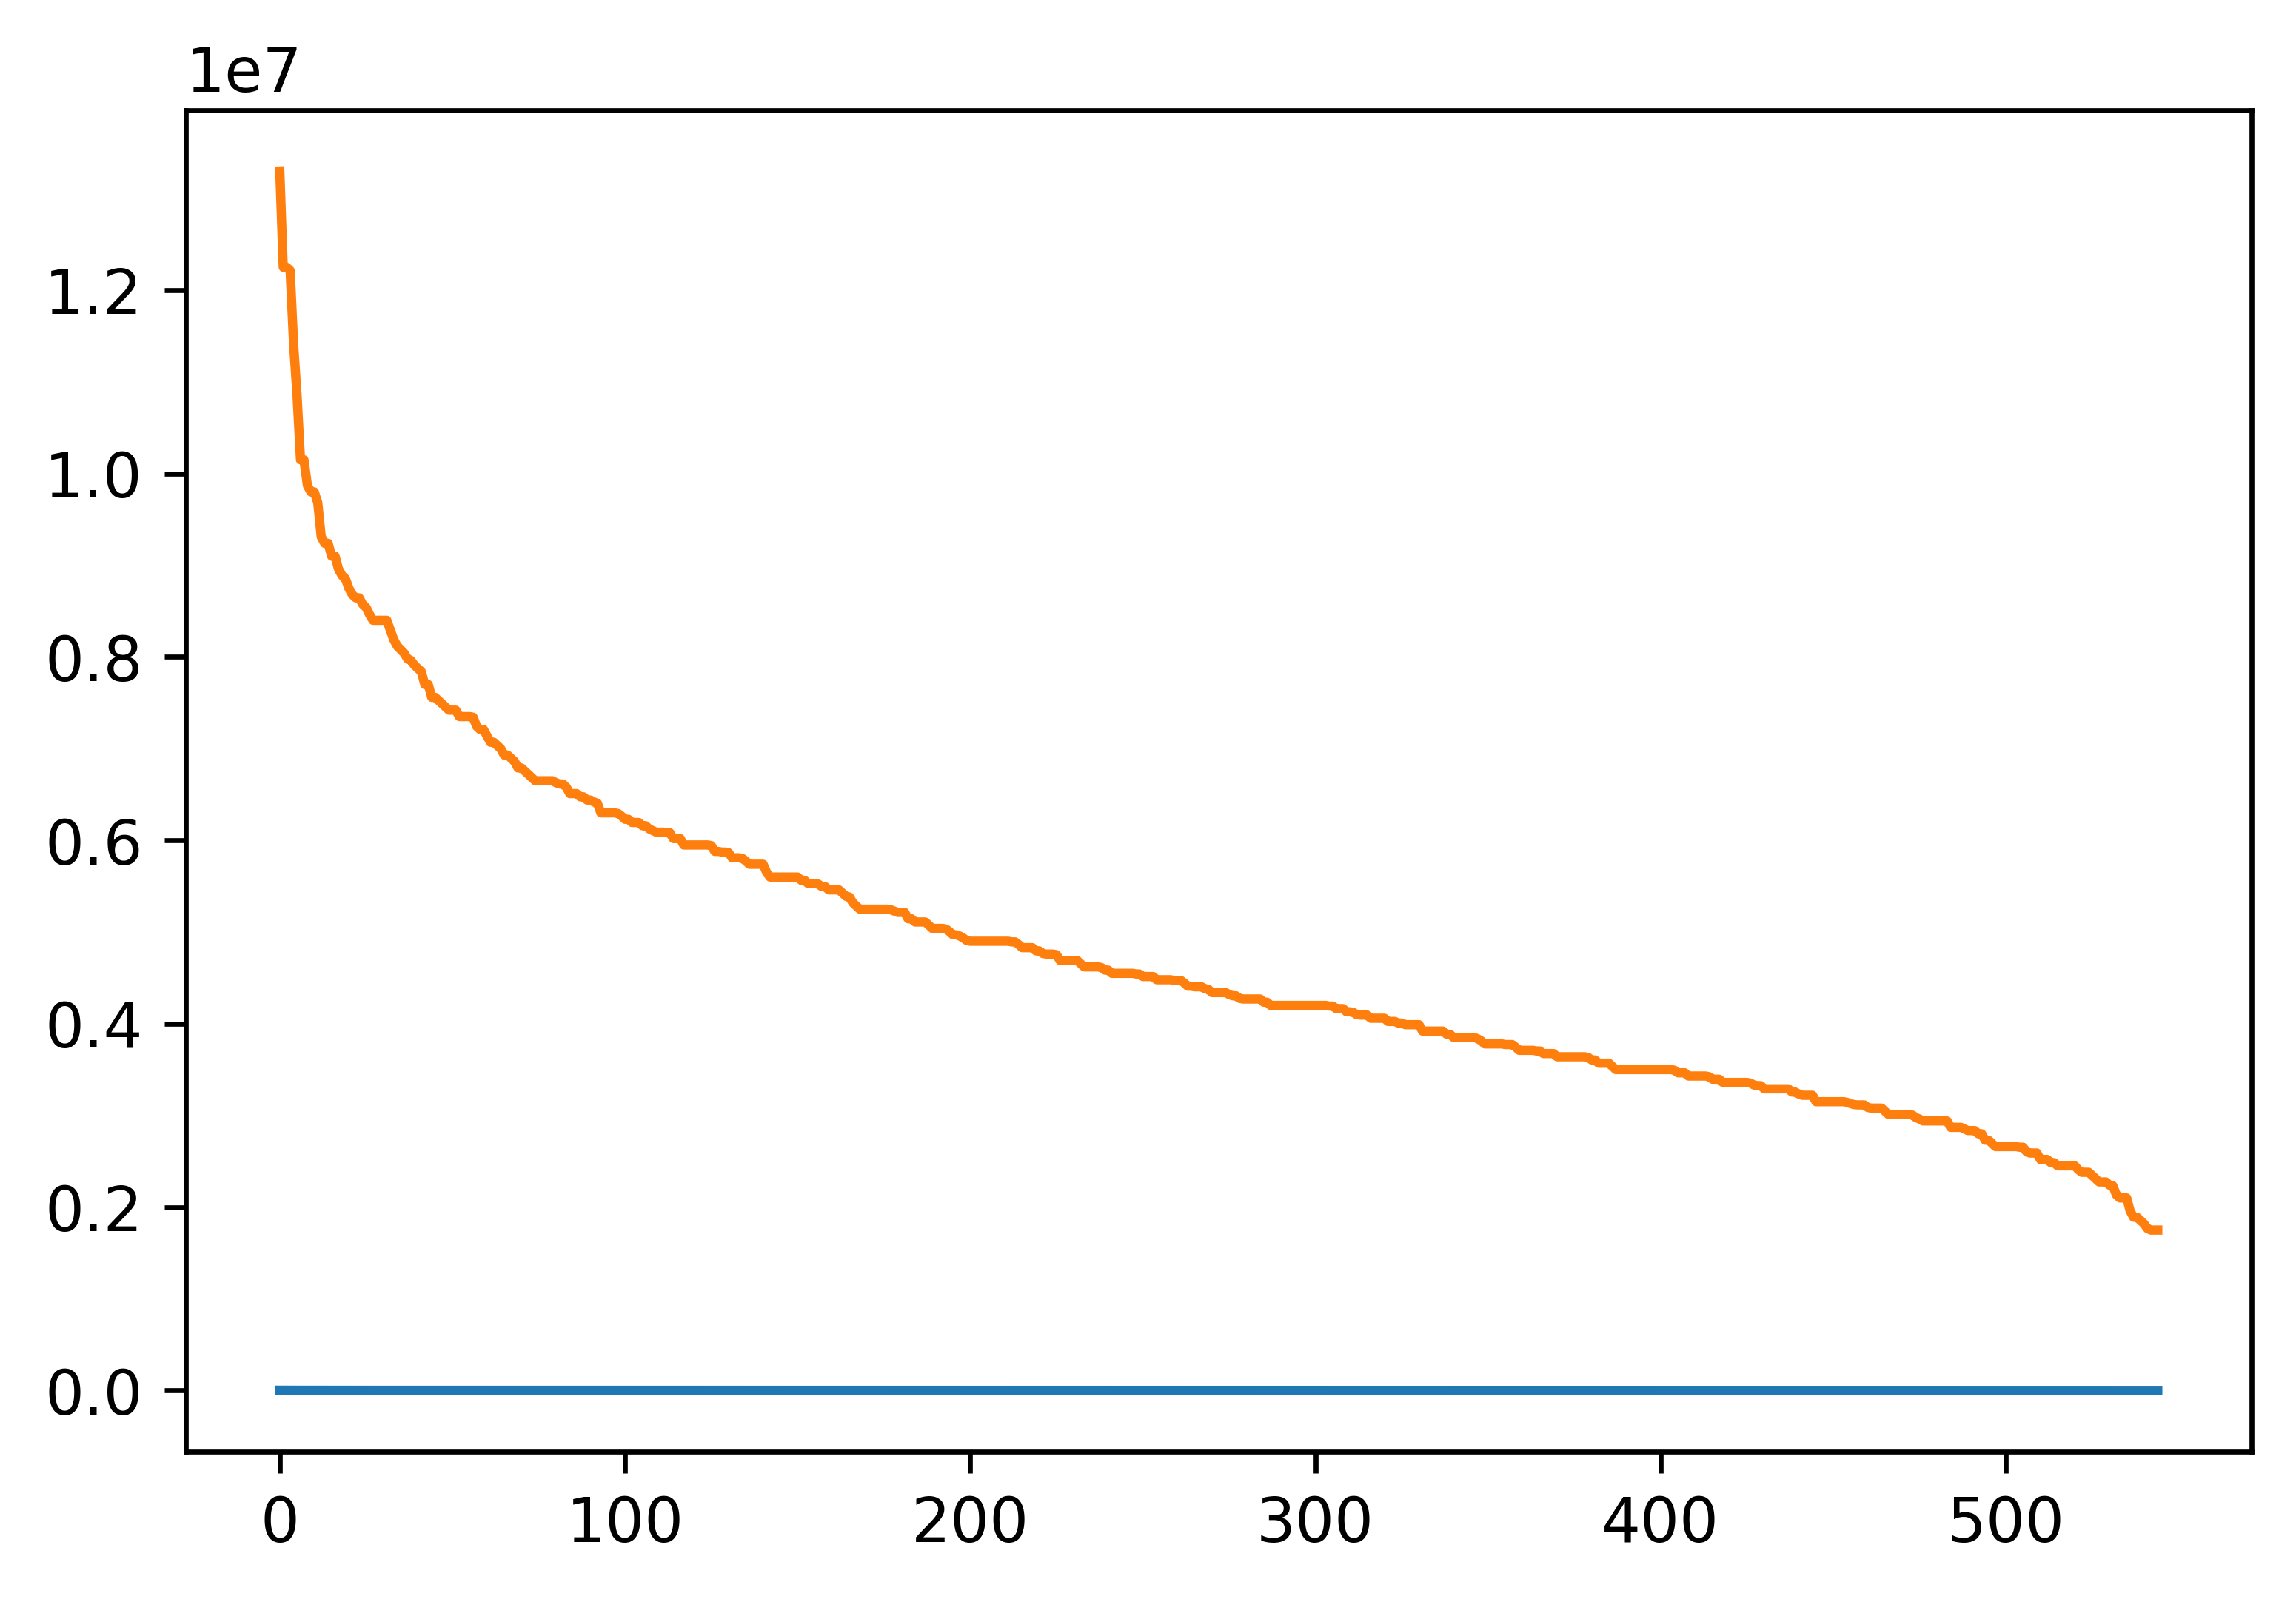

In [313]:
t_k = model(t_un, *parak)
fig = plt.figure(dpi=600)
plt.plot(t_k.detach().numpy())
plt.plot(t_u.detach().numpy())

The learning rate that was 1e-2 rapidly converged to a loss that was below 1. This is about the best loss that can be achieved, and it is possible that there was overfitting involved.

In [314]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.Adam([params], lr=learning_rate) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params,
    t_u = t_u, # <2> 
    t_c = t_c)

Epoch 500, Loss 5153420.500000
Epoch 1000, Loss 5153420.500000
Epoch 1500, Loss 5153420.500000
Epoch 2000, Loss 5153420.500000
Epoch 2500, Loss 5153420.500000
Epoch 3000, Loss 5153420.500000
Epoch 3500, Loss 5153420.500000
Epoch 4000, Loss 5153420.000000
Epoch 4500, Loss 5153420.000000
Epoch 5000, Loss 5153419.000000


tensor([ 2.0433e-04, -9.8668e-01], requires_grad=True)

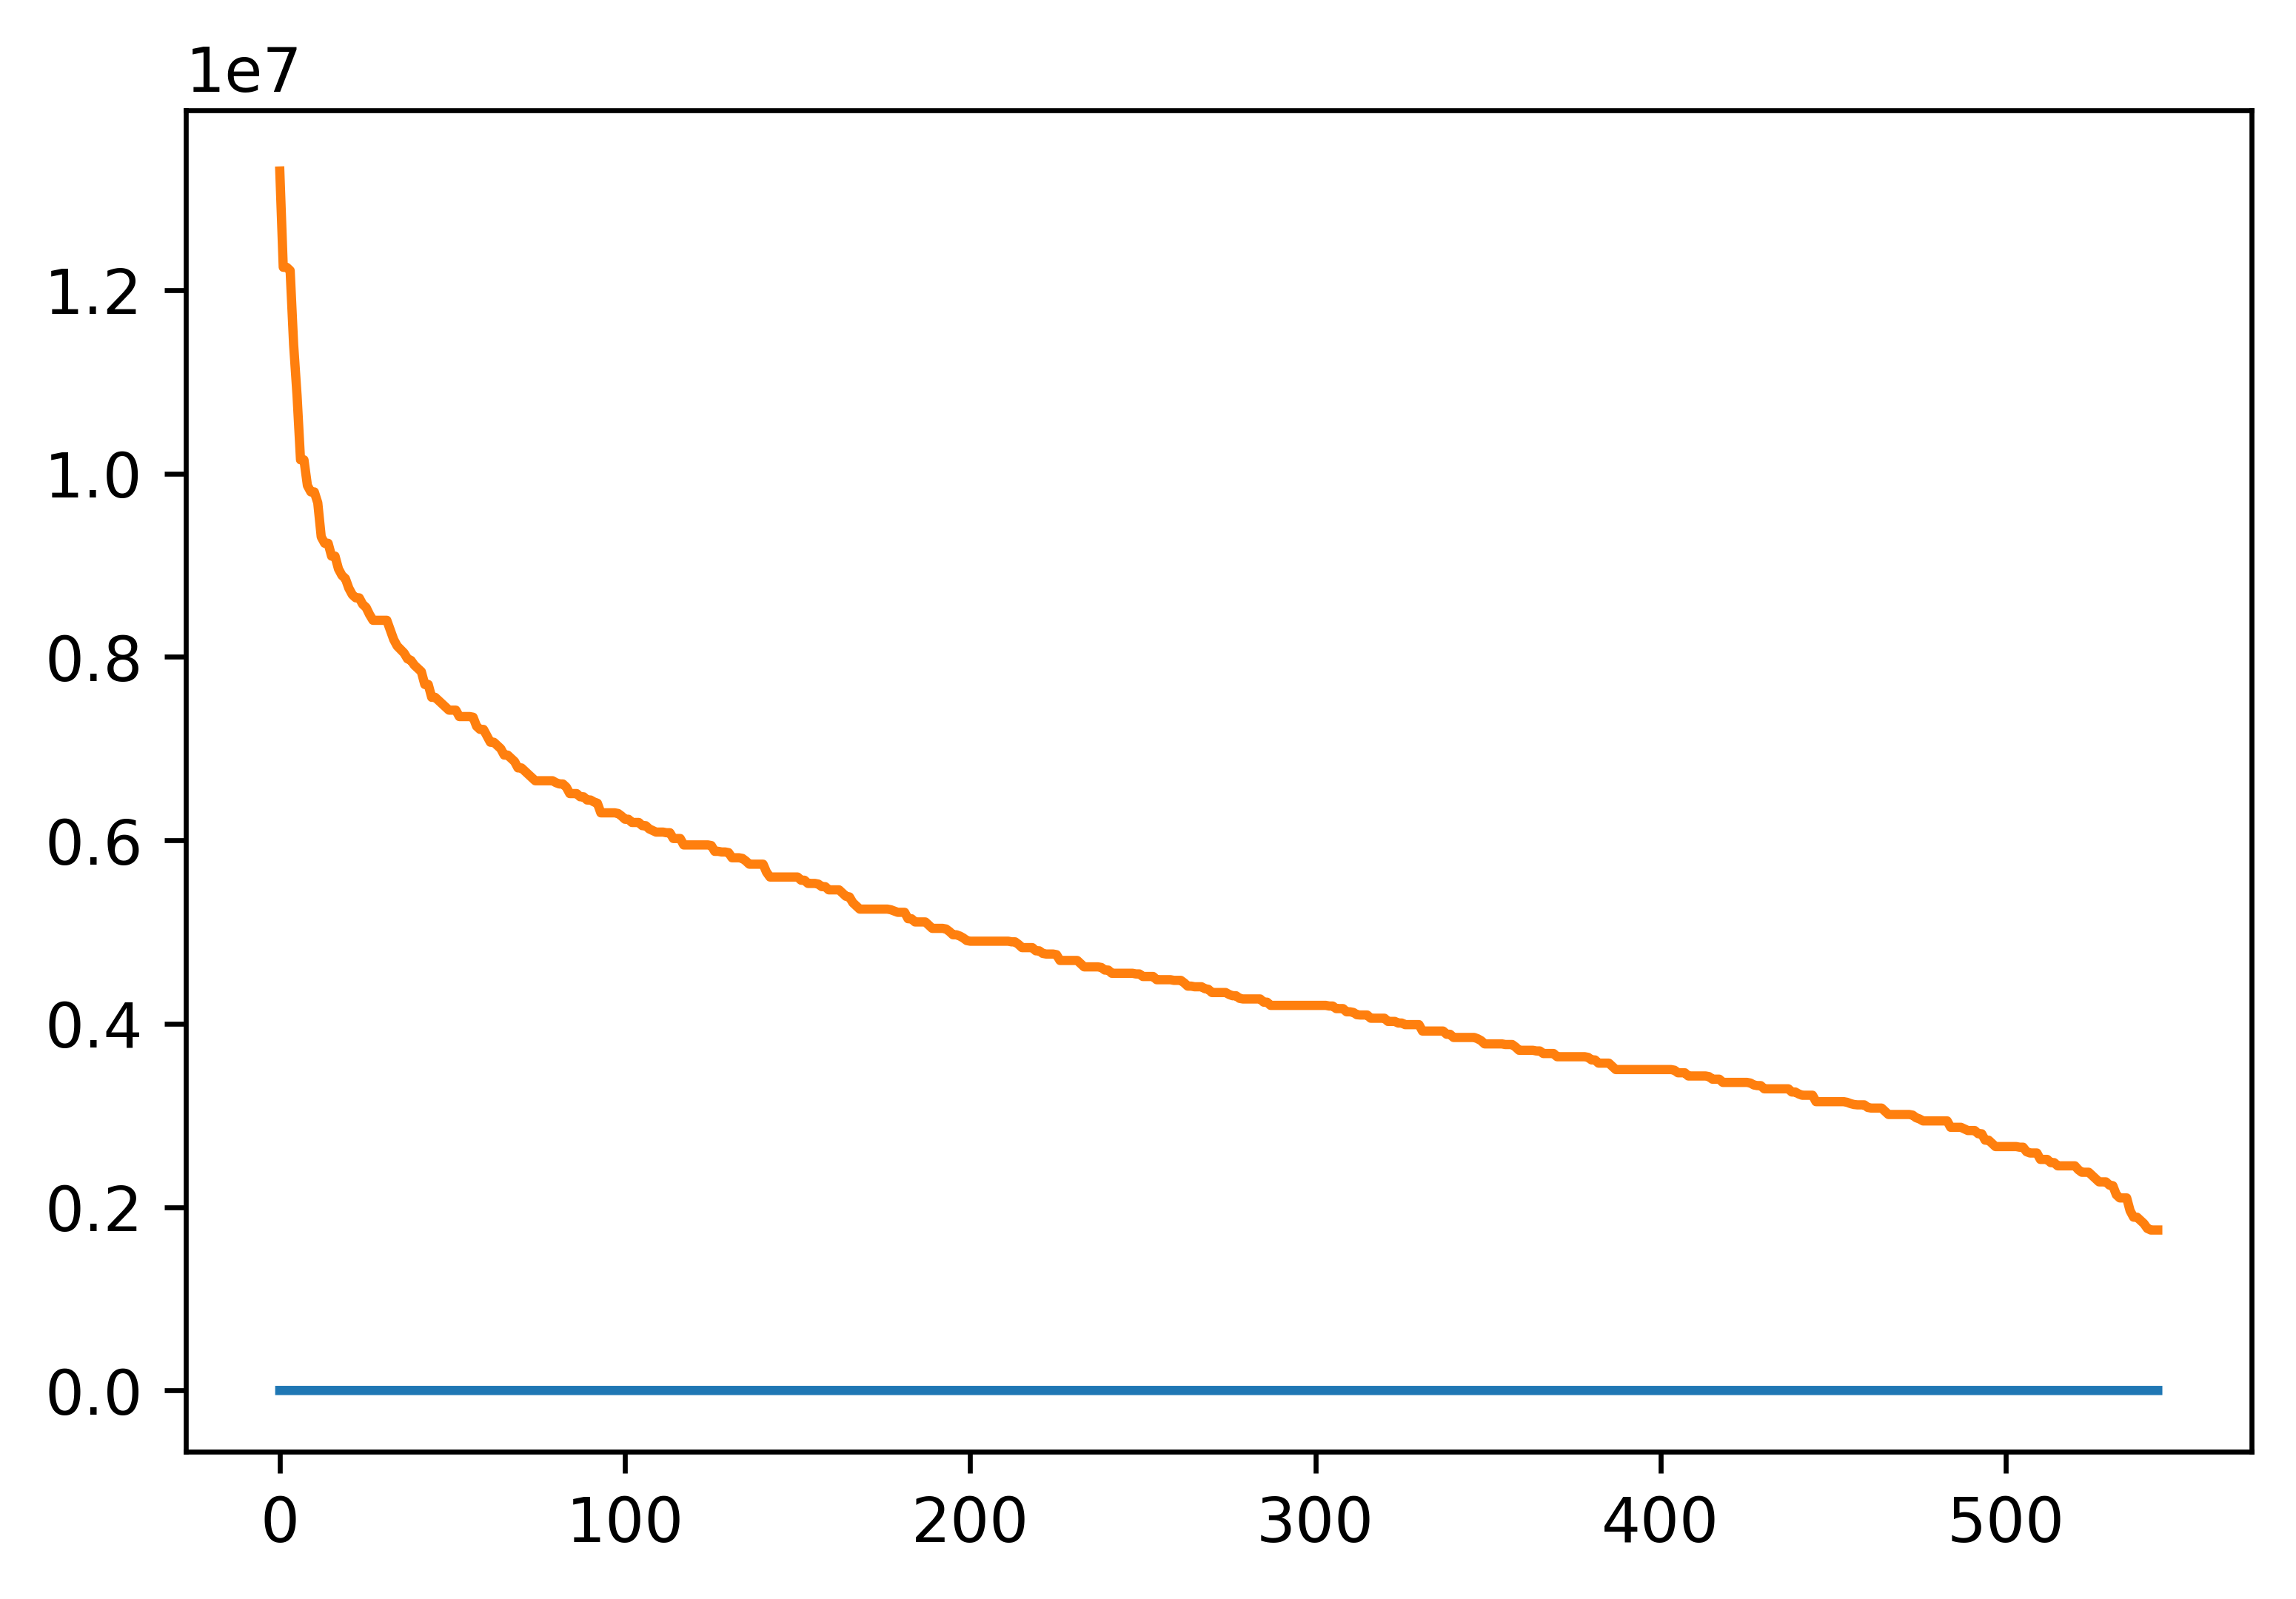

In [315]:
t_k = model(t_un, *params)
fig = plt.figure(dpi=600)
plt.plot(t_k.detach().numpy())
plt.plot(t_u.detach().numpy())

Strangely the 1e-3 learning rate converged to the same terminus of a little bit less than 1, but did so slower.

In [284]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-3
optimizer = optim.Adam([params], lr=learning_rate) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params,
    t_u = t_u, # <2> 
    t_c = t_c)

Epoch 500, Loss 8257512216108.820312
Epoch 1000, Loss 1746693501108.853516
Epoch 1500, Loss 207519669648.373444
Epoch 2000, Loss 11267955578.801189
Epoch 2500, Loss 222732286.802239
Epoch 3000, Loss 1203646.180249
Epoch 3500, Loss 1201.365189
Epoch 4000, Loss 1.093648
Epoch 4500, Loss 0.966550
Epoch 5000, Loss 0.966550


tensor([ 1.8184e-07, -1.0000e+00], requires_grad=True)

Strangely, the 1e-4 learning_rate produces a massive loss, though it was not quite large as the loss greated by the learning_rate of 1e-1, which overflowed.

In [319]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-4
optimizer = optim.Adam([params], lr=learning_rate) # <1>

para = training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params,
    t_u = t_u, # <2> 
    t_c = t_c)

Epoch 500, Loss 23680174260224.000000
Epoch 1000, Loss 21331317882880.000000
Epoch 1500, Loss 19146897096704.000000
Epoch 2000, Loss 17114511441920.000000
Epoch 2500, Loss 15224084103168.000000
Epoch 3000, Loss 13467526365184.000000
Epoch 3500, Loss 11838409408512.000000
Epoch 4000, Loss 10331643445248.000000
Epoch 4500, Loss 8943102328832.000000
Epoch 5000, Loss 7669367701504.000000


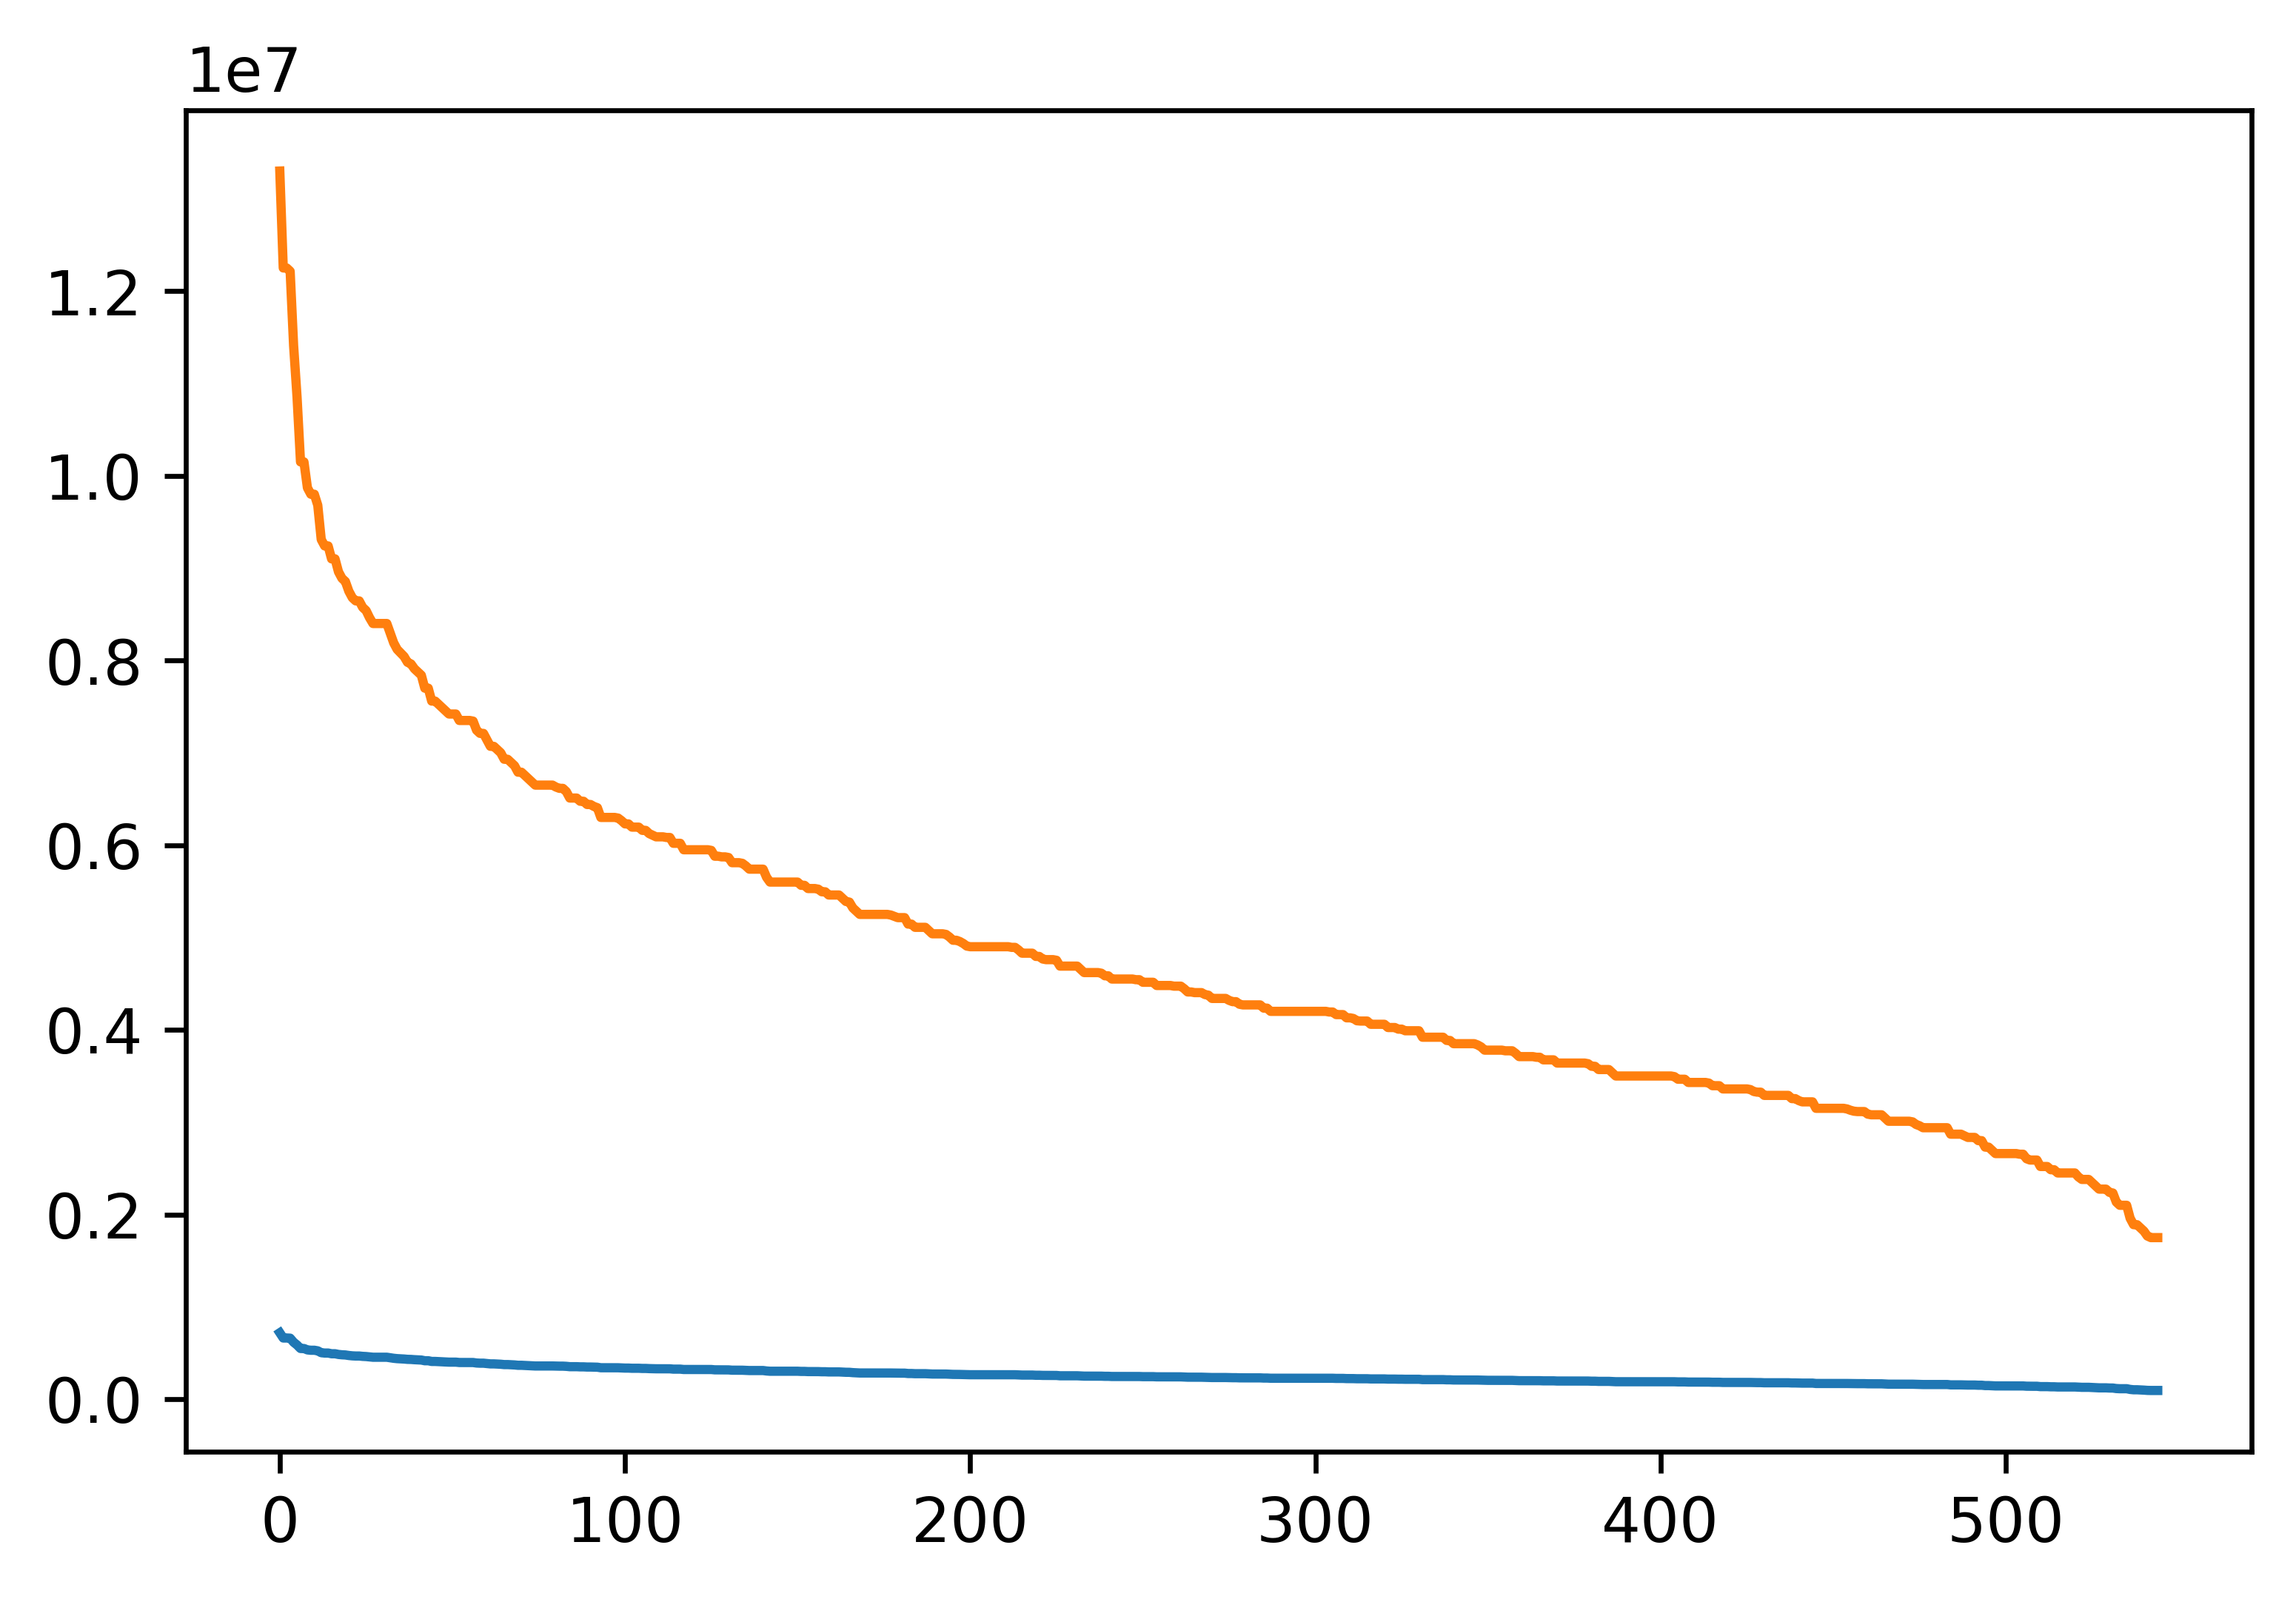

In [320]:
t_k = model(t_un, *para)
fig = plt.figure(dpi=600)
plt.plot(t_k.detach().numpy())
plt.plot(t_u.detach().numpy())